# Predicting Loan Defaults Of Lending Club Loans

## 1. Synopsis

LendingClub is an online marketplace for Peer-to-Peer lending and has issued over $20 billion in loans since it was first launched in 2007. Investors in LendingClub can choose to invest in Notes (fractions of individual borrower loans) of a diversified portfolio of loans. LendingClub assigns a loan grade between A and G based on borrower credit quality and underlying risk. Investors choose their portfolio based on the loan grades.  One would assume that the higher loan grades would have practically nil or very low default rates. But data shows otherwise – Even Grade A, B loans have a default rate of 7-15\%\. With a well-diversified portfolio, defaults may not do much harm, but all the same we would like to minimize the defaults as much as possible.  So, it would be of significant use for LendingClub and its investors to have a predictive model that will predict whether a given loan will default or not and use this prediction in the choice of loans to be funded.

We have used the loan data provided by LendingClub from 2012 to 2015 for building and testing a predictive model. Among the multiple machine learning algorithms that we tried, including a Voting Ensemble, we found that a model based on Extreme Gradient Boosting gave better results compared to others.

The implementation has been done using Python, pandas for data wrangling and scikit-learn for machine learning.

## 2.	Dataset & Labelling loans

The LendingClub has made its datasets of complete loan data open to the public at https://www.lendingclub.com/info/download-data.action . Each dataset contains the latest status for the loans originated in the stated period. For this study, three datasets containing loan data issued from 2012 through 2015 have been used – viz, Loans 2012-2013, Loans 2014 & Loans 2015.

There are 7 possible loan statuses –* Fully Paid, Current, In Grace Period, Late (16-30 days), Late (31-120 days), Default, Charged Off *

For this analysis & classification, we consider the statuses *Late (31-120 days), Default, Charged Off*  as **Bad** loans & the status *Fully Paid* as **Good** loans. All other loan statuses (*Current, In Grace Period, Late (16-30 days)*) are ignored since these loans could end up either way and we do not want to use them with partial information in our supervised learning algorithms.

The 9-month loan status migration rate in the below chart as provided by LendingClub compels us to consider the *Late (31-120 days), Default* statuses as **Bad** loans, since at least 77- 90% of these loans end up being Charged Off in 9 months


<img src="LC-Loanstatusmigration.png" style="width: 50%; height: 50%"/>
"Image Source: Lending Club Website https://www.lendingclub.com/info/demand-and-credit-profile.action")

## 3. Analysis


### 3.1 Dataset loading, cleanup and transformations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ml as pdml

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Loans with statuses *Late (31-120 days), Default, Charged Off , Fully Paid* as mentioned above have been retained, removing all other statuses.

In [2]:
# Read the datasets and retain only the records with loan_statuses Fully Paid, Charged Off, Default, Late (31-120 days)

# Define a function for string % convertion to a float ratio
def p2f(x):
    perc = None
    if (x != None) :
        if (type(x) is str) :
            x = x.strip('%')
        perc = float(x)/100
    return perc

loans_2014 = pd.read_csv('./LoanStats2014.csv', skiprows=1, skipfooter=2, parse_dates = [15, 26, 45,47, 48], 
                        infer_datetime_format = True, engine = 'python', converters = {'int_rate' : p2f, 'revol_util' : p2f})
loans_2014 = loans_2014[loans_2014.loan_status.isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])]

In [3]:
loans_1213 = pd.read_csv('./LoanStats2012to2013.csv', skiprows=1, skipfooter=2, parse_dates = [15, 26, 45,47, 48], 
                        infer_datetime_format = True, engine = 'python', converters = {'int_rate' : p2f, 'revol_util' : p2f})
loans_1213 = loans_1213[loans_1213.loan_status.isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])]


A very less number of loans, a few hundred, were of ‘JOINT’ application type. These loans have been removed from analysis as a bulk of credit history features may not be fully applicable for these kinds of loans. 

In [4]:
loans_2015 = pd.read_csv('./LoanStats2015.csv', skiprows=1, skipfooter=2, parse_dates = [15, 26, 45,47, 48], 
                        infer_datetime_format = True, engine = 'python', converters = {'int_rate' : p2f, 'revol_util' : p2f})
loans_2015 = loans_2015[(loans_2015.loan_status.isin(['Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'])) & (loans_2015.application_type == 'INDIVIDUAL')] 

In [14]:
#Merging the datasets
frames = [loans_1213,loans_2014, loans_2015]
loan_data = pd.concat(frames, axis = 0)

The older datasets may not have data for few features that are available in the later dataset of 2015. For eg, FICO score high and low range, total balance across all trades etc. Only the features that are available across all the datasets have been retained.

In [15]:
#Removing the attribute columns that have all null values. Only the attributes listed in the DataDictionary will remain.
# Since 2012-2013 dataset is having the minimal features, using that as the reference for column list
loans_1213.dropna(axis = 1, how = 'all', inplace= True)
loan_data = loan_data[loans_1213.columns]

In [16]:
#calculating roi. This is used later for evaluating the effectiveness of models
loan_data['roi_inv'] = (loan_data.total_pymnt_inv - loan_data.funded_amnt_inv) / loan_data.funded_amnt_inv

Some loan records do not have data for some of the critical credit history features (*tot_hi_cred_lim, tot_cur_bal, num_tl_120dpd_2m, revol_util, bc_open_to_buy, bc_util,  mths_since_recent_bc, pct_tl_nvr_dlq, num_rev_accts* ). Since this kind of information is highly subjective, it maybe misrepresentation of facts if we impute this missing data with the median or mean value. So it was decided to drop records with values missing for any of these features.

The dataset includes some features related to the loan repayment details, viz, *issue_d , next_pymnt_d, last_pymnt_d , collection_recovery_fee , last_pymnt_amnt , out_prncp , out_prncp_inv , recoveries , total_pymnt , total_pymnt_inv , total_rec_int , total_rec_late_fee , total_rec_prncp *. These features are clear giveaways of whether the loan is going good or bad and obviously will not be known at the time of approval or funding of the loan. So these features have been removed from the predictor variables list.

In [17]:
#Dropping textual and informational columns from the dataset
loan_data.drop(['emp_title', 'desc', 'title', 'addr_state', 'zip_code','application_type'  ], axis = 1, inplace = True)

#Removing some loan records which have nans for many critical features. (total credit limit, accounts past due etc)
loan_data.dropna(axis = 0, how = 'any', subset = ['tot_hi_cred_lim', 'tot_cur_bal', 'num_tl_120dpd_2m', 'revol_util',
                                             'bc_open_to_buy', 'bc_util', 'mths_since_recent_bc', 'pct_tl_nvr_dlq', 'num_rev_accts'], 
             inplace = True)
#Dropping loan repayment releated features 
loan_data.drop(['issue_d', 'next_pymnt_d', 'collection_recovery_fee', 'last_pymnt_amnt','out_prncp', 
                'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 
                'total_rec_prncp'], axis = 1, inplace = True)

In [18]:
#revol_util is being cast as object due to some unknown reason - forcing to float
loan_data['revol_util'] = loan_data['revol_util'].astype(np.float64)

One of the features that needed to be removed was the date of last Credit History pull by LC. For loans that were Charged Off or Fully Paid around the same time, one wouldn’t expect the time since last Credit pull to be different. However, the below chart shows that LC continues to pull Credit History for Charged Off loans but not for Fully Paid loans. So this feature was removed from the predictor list as this is an ‘after-the-fact’ feature that will not be known at the time of approval or funding of the loan.

(0, 65)

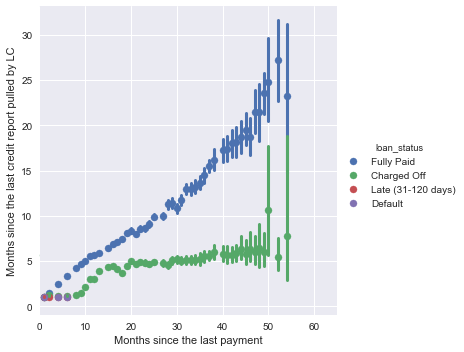

In [19]:
from datetime import datetime
#For plotting mo_sin_last_pymnt vs mo_sin_last_credit_pull
loan_data['last_pymnt_d'] = loan_data['last_pymnt_d'].fillna(pd.to_datetime('2017-05-03'))
loan_data['mo_sin_last_pymnt'] = ((datetime.strptime('2017-04-02', '%Y-%m-%d') - loan_data['last_pymnt_d']) / np.timedelta64(1, 'M')).astype(int)

loan_data['last_credit_pull_d'] = loan_data['last_credit_pull_d'].fillna(pd.to_datetime('2017-05-03'))
loan_data['mo_sin_last_credit_pull'] = ((datetime.strptime('2017-04-02', '%Y-%m-%d') - loan_data['last_credit_pull_d']) / np.timedelta64(1, 'M')).astype(int)

ax = sns.lmplot(x = 'mo_sin_last_pymnt', y = 'mo_sin_last_credit_pull', data = loan_data, hue = 'loan_status', x_estimator= np.mean, 
           fit_reg=False, ci = 99.5)
ax.set_xlabels('Months since the last payment')
ax.set_ylabels('Months since the last credit report pulled by LC')
ax.ax.set_xlim(0, 65)

In [20]:
#Removing the fields related to last credit pull
loan_data.drop(['last_credit_pull_d', 'mo_sin_last_credit_pull', 'last_pymnt_d', 'mo_sin_last_pymnt'], axis = 1, inplace = True)

In [21]:
#Transform date fields into appropriate duration units
from datetime import datetime
ref_datetime = datetime.strptime('2017-04-02', '%Y-%m-%d')

# Earliest credit line
loan_data['mo_sin_earliest_cr_line'] = ((ref_datetime - loan_data['earliest_cr_line']) / np.timedelta64(1, 'M')).astype(int)

loan_data.drop([ 'earliest_cr_line'], axis = 1, inplace = True)

Imputing missing values – Some features have a definitive meaning when the value is not present. For eg, *mths_since_last_delinq* , months since last delinquent payment by the borrower will be null when the borrower has never been delinquent before. So the missing values for these features (*mths_since_last_delinq, mths_since_last_record , mths_since_last_major_derog , mo_sin_old_il_acct , mths_since_recent_bc_dlq , mths_since_recent_inq  , mths_since_recent_revol_delinq* )  have been imputed to -1 to set these apart.

In [22]:
# Imputing missing values

#mths_since_last_delinq
# this will be null when the applicant has no prior delinquencies. Imputing these to -1 to set these apart.
loan_data['mths_since_last_delinq'] = loan_data['mths_since_last_delinq'].fillna(-1)

#mths_since_last_record
# this will be null when the applicant has no public records. Imputing these to -1 to set these apart.
loan_data['mths_since_last_record'] = loan_data['mths_since_last_record'].fillna(-1)

#mths_since_last_major_derog
# this will be null when the applicant has no previous derogatory records. Imputing these to -1 to set these apart.
loan_data['mths_since_last_major_derog'] = loan_data['mths_since_last_major_derog'].fillna(-1)

#mo_sin_old_il_acct
# this will be null when the applicant has no bank installment accounts. Imputing these to -1 to set these apart.
loan_data['mo_sin_old_il_acct'] = loan_data['mo_sin_old_il_acct'].fillna(-1)

#mths_since_recent_bc_dlq
# this will be null when there's no previous bankcard delinquency. Imputing these to -1 to set these apart.
loan_data['mths_since_recent_bc_dlq'] = loan_data['mths_since_recent_bc_dlq'].fillna(-1)

#mths_since_recent_inq
# this will be null when there's no previous inquiries. Imputing these to -1 to set these apart.
loan_data['mths_since_recent_inq'] = loan_data['mths_since_recent_inq'].fillna(-1)

#mths_since_recent_revol_delinq
# this will be null when there's no previous revolving account delinquencies. Imputing these to -1 to set these apart.
loan_data['mths_since_recent_revol_delinq'] = loan_data['mths_since_recent_revol_delinq'].fillna(-1)


Some of the features like( *tot_cur_bal , revol_bal, avg_cur_bal, bc_open_to_buy, delinq_amnt, total_bal_ex_mort, total_bc_limit, total_il_high_credit_limit*) carry absolute dollar value. However these values make a true meaning only in comparison to the borrower’s annual income. So these features were converted as a fraction of annual income.

In [23]:
# Converting absolute dollar values as a fraction of the borrower's annual income.
loan_data['revol_bal_over_annual_inc'] = loan_data.revol_bal / loan_data.annual_inc
loan_data['tot_cur_bal_over_annual_inc'] = loan_data.tot_cur_bal / loan_data.annual_inc
loan_data['avg_cur_bal_over_annual_inc'] = loan_data.avg_cur_bal / loan_data.annual_inc
loan_data['bc_open_to_buy_over_annual_inc'] = loan_data.bc_open_to_buy / loan_data.annual_inc
loan_data['delinq_amnt_over_annual_inc'] = loan_data.delinq_amnt / loan_data.annual_inc
loan_data['total_bal_ex_mort_over_annual_inc'] = loan_data.total_bal_ex_mort / loan_data.annual_inc
loan_data['total_bc_limit_over_annual_inc'] = loan_data.total_bc_limit / loan_data.annual_inc
loan_data['total_il_high_credit_limit_over_annual_inc'] = loan_data.total_il_high_credit_limit / loan_data.annual_inc

loan_data.drop(['revol_bal', 'tot_cur_bal', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt','total_bal_ex_mort', 'total_bc_limit',
              'total_il_high_credit_limit'], axis=1, inplace = True)

The loan grade and sub-grade categorical features were converted to numerical values considering that the grade and sub-grade are ordered. So Grade A gets a higher value compared to Grade B and sub-grade A1 gets a higher value compared to sub-grade A2.

In [24]:
#Converting Grade and sub_grade to numeric.
loan_data['grade_numeric'] = loan_data.grade.astype("category", categories=['G', 'F','E', 'D', 'C', 'B', 'A'], ordered=True)
loan_data['grade_numeric'] = loan_data.grade_numeric.cat.codes
loan_data['grade_numeric'] = loan_data.grade_numeric.map(int)

loan_data['sub_grade_numeric'] = loan_data.sub_grade.astype("category", 
                                                          categories=['G5', 'G4', 'G3', 'G2', 'G1',
                                                                     'F5', 'F4', 'F3', 'F2', 'F1',
                                                                     'E5', 'E4', 'E3', 'E2', 'E1',
                                                                     'D5', 'D4', 'D3', 'D2', 'D1',
                                                                     'C5', 'C4', 'C3', 'C2', 'C1',
                                                                     'B5', 'B4', 'B3', 'B2', 'B1',
                                                                     'A5', 'A4', 'A3', 'A2', 'A1'], ordered=True)
loan_data['sub_grade_numeric'] = loan_data.sub_grade_numeric.cat.codes
loan_data['sub_grade_numeric'] = loan_data.sub_grade_numeric.map(int)

#loan_data.drop(['grade', 'sub_grade'], axis=1, inplace = True)

In [25]:
#Cleaning Emp length
loan_data['emp_length_numeric'] = loan_data.emp_length.str.replace('+','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('<','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('years','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('year','')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.str.replace('n/a','-1')
loan_data['emp_length_numeric'] = loan_data.emp_length_numeric.map(int)

loan_data.drop(['emp_length'], axis=1, inplace = True)

One Hot Encoding for categorical features – The categorical features (home_ownership , verification_status , pymnt_plan, purpose, initial_list_status, term)were one-hot-encoded

In [26]:
# Convert categorical features to One Hot Encode format using Pandas getDummies
categorical_features = [ 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'term']
loan_data = pd.get_dummies(columns = categorical_features, data= loan_data, )

The loans were labelled as Good (0) or Bad (1) as mentioned in the above section and the label was marked as the target variable.

In [27]:
# Classify the loans as 'Good' ,'Bad', 'Delinquent'

def classify_loan(row) :
    val = ''
    #if ((row.loan_status in ['Fully Paid', 'Current']) ) :
    if ((row.loan_status in ['Fully Paid']) ) :
        val = '0-Good'
    else :
        val = '1-Bad'
    return val

loan_data['loan_class'] = loan_data.apply(classify_loan, axis = 1)

In [28]:
pd.DataFrame(loan_data.groupby('loan_class').size())

,0
loan_class,
0-Good,328825
1-Bad,98931


In [29]:
# Identifying X values - Removing the label columns and transformed features
#X = loan_data.drop(['loan_status', 'loan_class', 'grade', 'sub_grade'], axis = 1)
X = loan_data.drop(['loan_status', 'loan_class',  'sub_grade'], axis = 1)

loan_data['loan_class'] = loan_data.loan_class.astype('category')
Y = loan_data.loan_class.cat.codes


In [30]:
#create ModelFrame object & write to file for later re-run
loans_mf = pdml.ModelFrame(X, target = Y)
loans_mf.to_csv('prepared_loans.csv', index = False)

## 3.2 Exploratory Analysis

Note that all analysis and predictions are based on Fully Paid, Charged Off, Default & Late (31-120 days) loans and we have excluded all current loans and loans that are up to 30 days late

### 3.2.1 Loans by Loan Label (Good / Bad) 

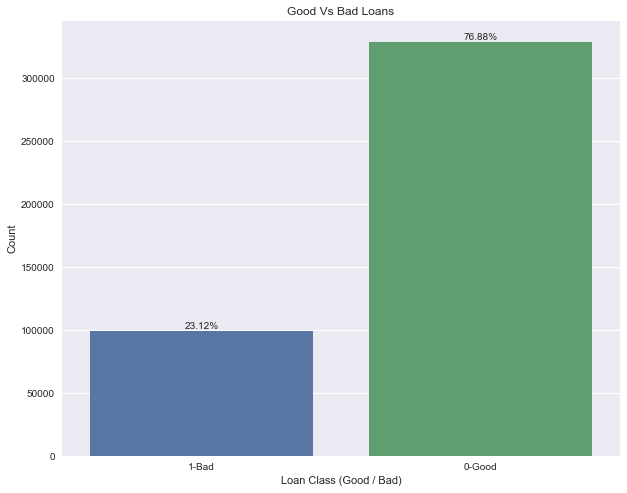

In [31]:
#Loans by Loan class
sns.set_context({"figure.figsize": (10, 8)})
ax = sns.countplot(x = 'loan_class', data = loan_data, order = ['1-Bad', '0-Good'])
ax.set_xlabel('Loan Class (Good / Bad)')
ax.set_ylabel('Count')
ax.set_title('Good Vs Bad Loans')

# Now make some labels
labels = ['23.12%', '76.88%']
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    

In [32]:
#Loan Amount by Loan class
by_class = loan_data.groupby('loan_class').agg({'loan_amnt': 'sum'})
by_class =pd.DataFrame( by_class)
#by_class.index.name = None
#by_class.columns.name = None
total = np.sum(by_class)
by_class['perc'] = (by_class.div(total) * 100)
by_class['perc'] = by_class.perc.apply("{0:.2f}%".format)
by_class.reset_index(inplace = True)
by_class.rename(columns = { 'index' : 'loan_class'}, inplace = True)
by_class['loan_amnt'] = by_class.loan_amnt / 1000000000
by_class

,loan_class,loan_amnt,perc
0,0-Good,4.690903,75.35%
1,1-Bad,1.534366,24.65%


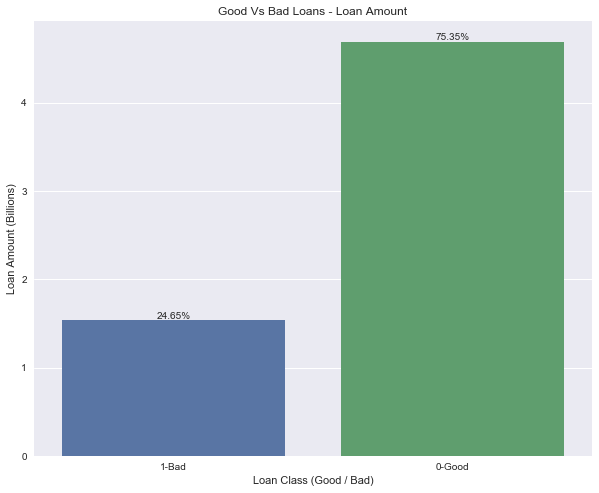

In [33]:
ax1 = sns.barplot(x = 'loan_class', y = 'loan_amnt', data = by_class, order = ['1-Bad', '0-Good'])
ax1.set_xlabel('Loan Class (Good / Bad)')
ax1.set_ylabel('Loan Amount (Billions)')
ax1.set_title('Good Vs Bad Loans - Loan Amount')

# Now make some labels
labels =['24.65%', '75.35%']
rects = ax1.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height , label, ha='center', va='bottom')

### 3.2.2 How does the Default rate vary across the loan grades

LC assigns loan grades based on the quality of borrower credit history. So higher grade loans are expected to have lower default rates. Let’s see the trend below.

In [34]:
#Loans by Grade
by_grade = loan_data.groupby(['grade', 'loan_class']).size()
#grade_total = loan_data.groupby('grade').size()
#by_grade_target_perc = by_grade.div(grade_total, level = 'grade').mul(100, level = 'grade')
#by_grade_target_perc = by_grade_target_perc.apply("{0:.2f}%".format)
by_grade = by_grade.unstack()
by_grade.index.name = None
by_grade.columns.name = None
by_grade.rename(columns = { '0-Good' : 'Good', '1-Bad': 'Bad'}, inplace = True)
by_grade['Total'] = by_grade.Good + by_grade.Bad
by_grade.loc['F + G'] = by_grade.loc['F'] + by_grade.loc['G']
by_grade.drop(['F', 'G'], inplace=True)
by_grade.reset_index(inplace = True)
by_grade.rename(columns = { 'index' : 'Grade'}, inplace = True)
by_grade

,Grade,Good,Bad,Total
0,A,60444,4768,65212
1,B,106253,18193,124446
2,C,87498,29477,116975
3,D,46492,23501,69993
4,E,20075,15102,35177
5,F + G,8063,7890,15953


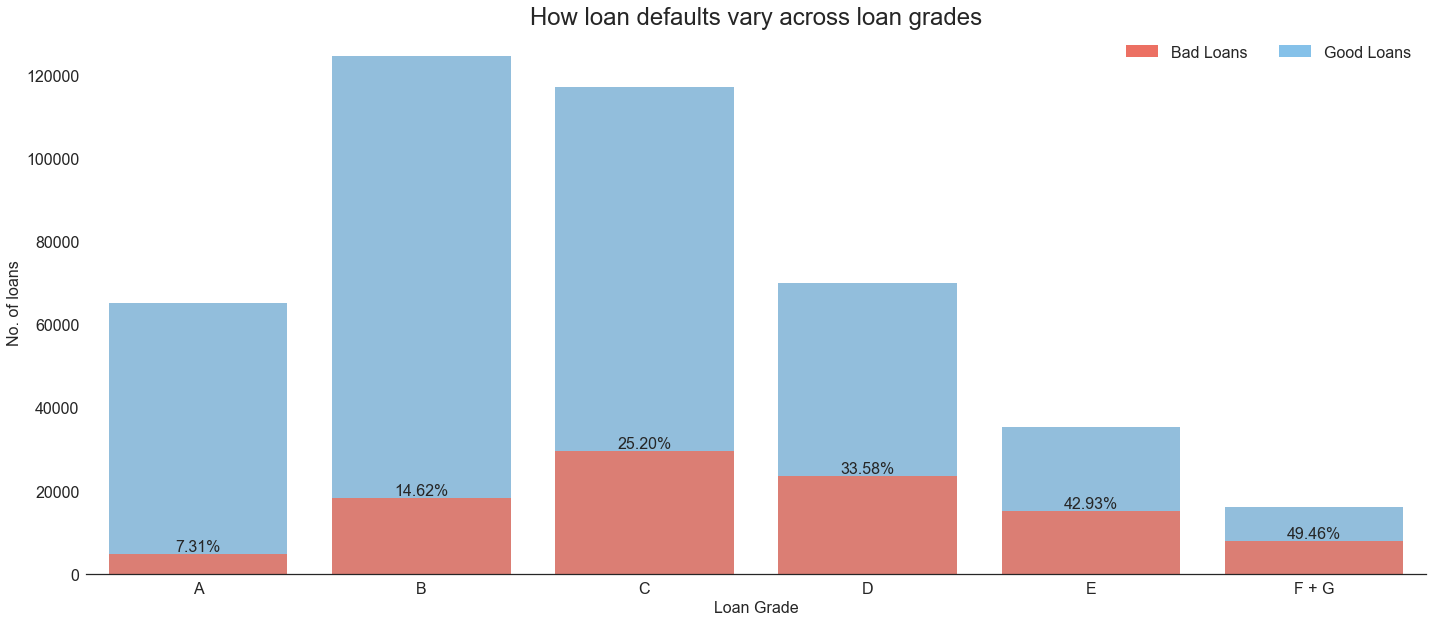

In [35]:
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

bottom_plot = sns.barplot(x = 'Grade', y = 'Bad', data= by_grade, color = "#EC7063")
rects = bottom_plot.patches

#Plot 1 - background - "total" (top) series
top_plot = sns.barplot(x = 'Grade', y = 'Total', data= by_grade, color = "#85C1E9")


#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = 'Grade', y = 'Bad', data= by_grade, color = "#EC7063")


topbar = plt.Rectangle((0,0),1,1,fc="#85C1E9", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#EC7063',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Bad Loans', 'Good Loans'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("No. of loans")
bottom_plot.set_xlabel("Loan Grade")

bottom_plot.set_title('How loan defaults vary across loan grades', fontsize = 24)
#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
    


# Now make some labels
labels = (by_grade.Bad / by_grade.Total *100).apply("{0:.2f}%".format)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    bottom_plot.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 16)


This trend of loan default rate can complement the insight provided by LC on the expected annualized return rate across grades. Please refer the figure below, originally provided by LendingClub

<img src='LC-Historicalreturnsbygrade.png' style="width: 50%; height: 50%"/>
"Image Source: Lending Club Website https://www.lendingclub.com/info/demand-and-credit-profile.action")

For eg: we can infer that although Grade E loans have an interest rate of 20.07%, the annualized return rate is only 6.34%, one of the main reason being that 42.93% of Grade E loans are at risk of default. 
Conversely, Grade A loans charge an interest rate of 7.34% and is able to provide annualized return of 4.95%, as the risk of default is less at 7.31%


### 3.2.3 How do the predictor variables vary for the Good / Bad loans

The below chart captures the density plot for all the predictor variables plotted separately for the Good & Bad loans. Here we see that there is considerable overlap in the value ranges for the predictor variables between the Good and Bad loans. There are some predictors that show a slight difference in the value trends, viz dti (debt to income ratio), int_rate, annual_inc etc. 

C:\Users\Anu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\Anu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


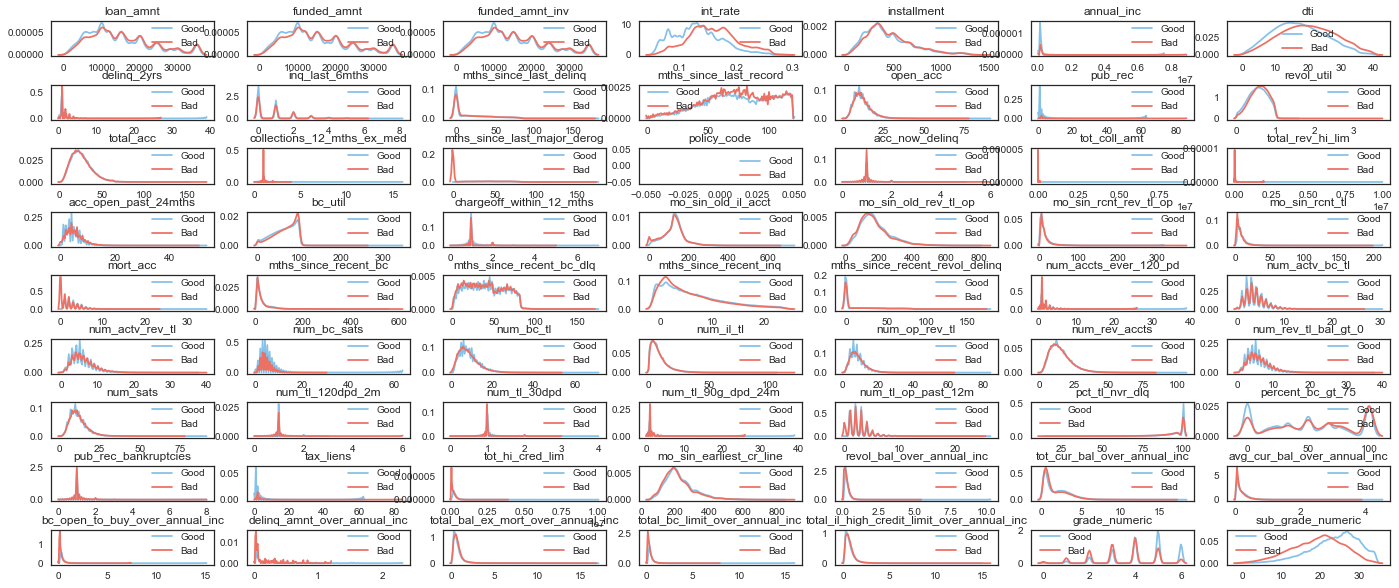

In [36]:
#Predictor variable trends
#Taking all predictor variables except the one-hot encoded categorical variables
cols_of_interest = X.drop(['roi_inv', 'grade'], axis = 1).columns[:64]
fig, axes = plt.subplots(9, 7)
plt.subplots_adjust(hspace = 0.8)
sns.set_context({"figure.figsize": (24, 16)})
good_loans = loan_data[loan_data.loan_class == '0-Good']
bad_loans = loan_data[loan_data.loan_class == '1-Bad']
for col, ax in zip(cols_of_interest, axes.reshape(-1)) :
    sns.kdeplot(good_loans[col], color ='#85C1E9', ax = ax, label = 'Good')
    sns.kdeplot(bad_loans[col], color ='#EC7063', ax = ax, label = 'Bad' )
    ax.set_title(col)

# 4. Predictive Model

## 4.1 Algorithms & Performance Metrics

The loan defaults or in general financial credit risk prediction is a tough task since there is no easily visible patterns. The dataset is imbalanced as one would expect, the default or ‘Bad’ class being at 23% of the completed loans (excluding ‘Current’ loans as mentioned previously). The dataset having 427K total records, out of which around 99K are labelled ‘Bad’ is split into train-test datasets at 80-20 ratio. 
 The idea is to train multiple models using different algorithms and build an ensemble of these models for the final prediction. The below models have been used to build the individual models. 
1.	Random Forest Model
2.	Extreme Gradient Boost Model
3.	Light Gradient Boost Model
4.	Voting Ensemble

Cross Validation has been used for hyper parameter tuning for the individual models. A smaller dataset of 60K records has been used for the train- test splits for cross validation. 
A probability threshold of 0.4 was used instead of the default 0.5 when labelling the predictions so as to pick up border cases of possible defaults as learned by the algorithms. 

Since the dataset is imbalanced, we cannot rely on accuracy alone for evaluating the model performance. We concentrate on the ROC & Precision-Recall values and particularly the AUC score. A loan being default or ‘Bad’ is the positive case here and we are interested in the True positives and False positives predicted by the model. 
We will also do a comparison of these metrics for all the models.

We have also trained a variation of each model using a SMOTE oversampled training dataset.




In [37]:
import xgboost as xgb
import lightgbm as lgb 

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing

from xgboost import plot_importance

In [38]:
#Read the prepared dataset
loans = pd.read_csv('prepared_loans.csv')
#create pandas_ml ModelFrame object
loans_mf = pdml.ModelFrame(loans.drop(['grade', 'roi_inv'], axis = 1))

In [39]:
#Split into training and test data sets
train_loans, test_loans = loans_mf.model_selection.train_test_split(test_size = 0.20, random_state = 6)
print("Train dataset\n", train_loans.target.value_counts())
print("\nTest dataset\n", test_loans.target.value_counts())

Train dataset
 0    263176
1     79028
Name: .target, dtype: int64

Test dataset
 0    65649
1    19903
Name: .target, dtype: int64


In [40]:
#Creating a SMOTE oversampled training dataset as well.
sampler = train_loans.imbalance.over_sampling.SMOTE()
sampled_lr_loans = train_loans.fit_sample(sampler)
print ("Over sampled Train dataset\n" , sampled_lr_loans.target.value_counts())

Over sampled Train dataset
 1    263176
0    263176
Name: .target, dtype: int64


In [41]:
# Create a smaller size training set for cross validation & hyper parameter tuning
loans_subset = pdml.ModelFrame(loans.sample(60000))
mini_train_loans, mini_test_loans = loans_subset.model_selection.train_test_split(test_size = 0.20, random_state = 6)


In [42]:
#Defining a method to compute all relevant train / test scores for a fitted model.
def score_the_model(train_mf, test_mf, alg, model_key, use_PredictProba = True, scale = False) :
    print("-----------------------------------------------------------------------------------------------------------")
    #print(model_key)
    if(scale == True) :
        train_data = preprocessing.scale(train_mf.data)
        test_data = preprocessing.scale(test_mf.data)
    else :
        train_data = train_mf.data
        test_data = test_mf.data
    if(use_PredictProba) :
        train_predict_prob = alg.predict_proba(train_data)[:,1]
        test_predict_prob = alg.predict_proba(test_data)[:,1]
    else :
        train_predict_prob=alg.predict(train_data)
        test_predict_prob=alg.predict(test_data)
    #Using a lower probability threshold of 0.4 to mark border case Bads as Bads
    train_predicted = np.array([0 if p < 0.4 else 1 for p in train_predict_prob])
    test_predicted = np.array([0 if p < 0.4 else 1 for p in test_predict_prob])

    tr_accuracy = accuracy_score(np.array(train_mf.target), train_predicted)
    te_accuracy = accuracy_score(np.array(test_mf.target), test_predicted)
    
    tr_auc = roc_auc_score(np.array(train_mf.target), np.array(train_predict_prob), average='weighted')
    te_auc = roc_auc_score(np.array(test_mf.target), np.array(test_predict_prob), average = 'weighted')
    
    tr_prec = average_precision_score(np.array(train_mf.target), np.array(train_predict_prob), average='weighted')
    te_prec = average_precision_score(np.array(test_mf.target), np.array(test_predict_prob), average = 'weighted')
    
    tr_f1 = f1_score(np.array(train_mf.target), np.array(train_predicted), average = 'weighted')
    te_f1 = f1_score(np.array(test_mf.target), np.array(test_predicted), average = 'weighted')

    prec, recall, f1, support = precision_recall_fscore_support(np.array(test_mf.target), np.array(test_predicted))
    te_0_prec, te_1_prec = prec[0], prec[1]
    te_0_rec, te_1_rec = recall[0], recall[1]
    te_0_f1, te_1_f1 = f1[0], f1[1]
    
    scores = pd.Series([model_key,tr_accuracy,te_accuracy,tr_auc,te_auc,tr_prec,te_prec,tr_f1,te_f1, te_0_prec,te_1_prec,
                         te_0_rec, te_1_rec,te_0_f1, te_1_f1], ['Model','Accuracy (Train)', 'Accuracy (Test)', 'AUC (Train)', 'AUC (Test)',
                                        'Precision (Train)', 'Precision (Test)','F1-Weighted (Train)', 'F1-Weighted (Test)',
                                        'Label-Good Precision (Test)','Label-Bad Precision (Test)', 'Label-Good Recall (Test)',
                                        'Label-Bad Recall (Test)','Label-Good F1 (Test)','Label-Bad F1 (Test)'  ] )
    
    return scores

In [43]:
# A Dataframe to hold all the model scores
allmodelscores = pd.DataFrame()


## 4.2 Random Forest Model

Based on Cross validation (*code and results available towards the end portion of the notebook*), it was concluded that training more than 200 trees doesn’t bump up the results too much. Similarly, increasing the max_features parameter to be more than the default value of square root of total features also doesn’t help much. A random Forest model with 200 trees, the sklearn default values for max_depth and max_features was trained on the training dataset. The parameter class_weight was set to ‘balanced’ so that the class imbalance is addressed.
Below is a summary of the results & a plot of the ROC curve.

In [44]:
#Random Forest estimator fit on regular training dataset
rf_est = loans_mf.ensemble.RandomForestClassifier(n_estimators = 60, criterion = 'gini', class_weight = 'balanced')
rf_est.fit(train_loans.data, train_loans.target)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
allmodelscores = allmodelscores.append(score_the_model(train_loans, test_loans, rf_est, model_key='Random Forest'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.713328,1.0,0.763688,0.999991,0.738409,0.999991,0.352248,0.486116,0.27619,0.855482,0.805964,0.911484,Random Forest,0.420832,1.0


In [46]:
#Random Forest estimator fit on oversampled training dataset
rf_est_smpled = loans_mf.ensemble.RandomForestClassifier(n_estimators = 60, criterion = 'gini', class_weight = 'balanced')
rf_est_smpled.fit(sampled_lr_loans.data, sampled_lr_loans.target)

allmodelscores = allmodelscores.append(score_the_model(sampled_lr_loans, test_loans, rf_est_smpled, model_key='Random Forest with Oversampling'), ignore_index=True)
allmodelscores.tail(2)

-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.713328,1.0,0.763688,0.999991,0.738409,0.999991,0.352248,0.486116,0.276190,0.855482,0.805964,0.911484,Random Forest,0.420832,1.0
1,0.714428,1.0,0.748457,0.999983,0.741693,0.999983,0.419195,0.452854,0.390192,0.839465,0.822566,0.857073,Random Forest with Oversampling,0.422368,1.0


Here we can see that using oversampled learning dataset has helped improve the recall rate for the ‘Bad’ class from 27% to 39%, though affecting the precision to go down to 45% from 49%. This is when a threshold of 0.4 is used to label the ‘Bad’ loans.

### 4.2.1 ROC Curve

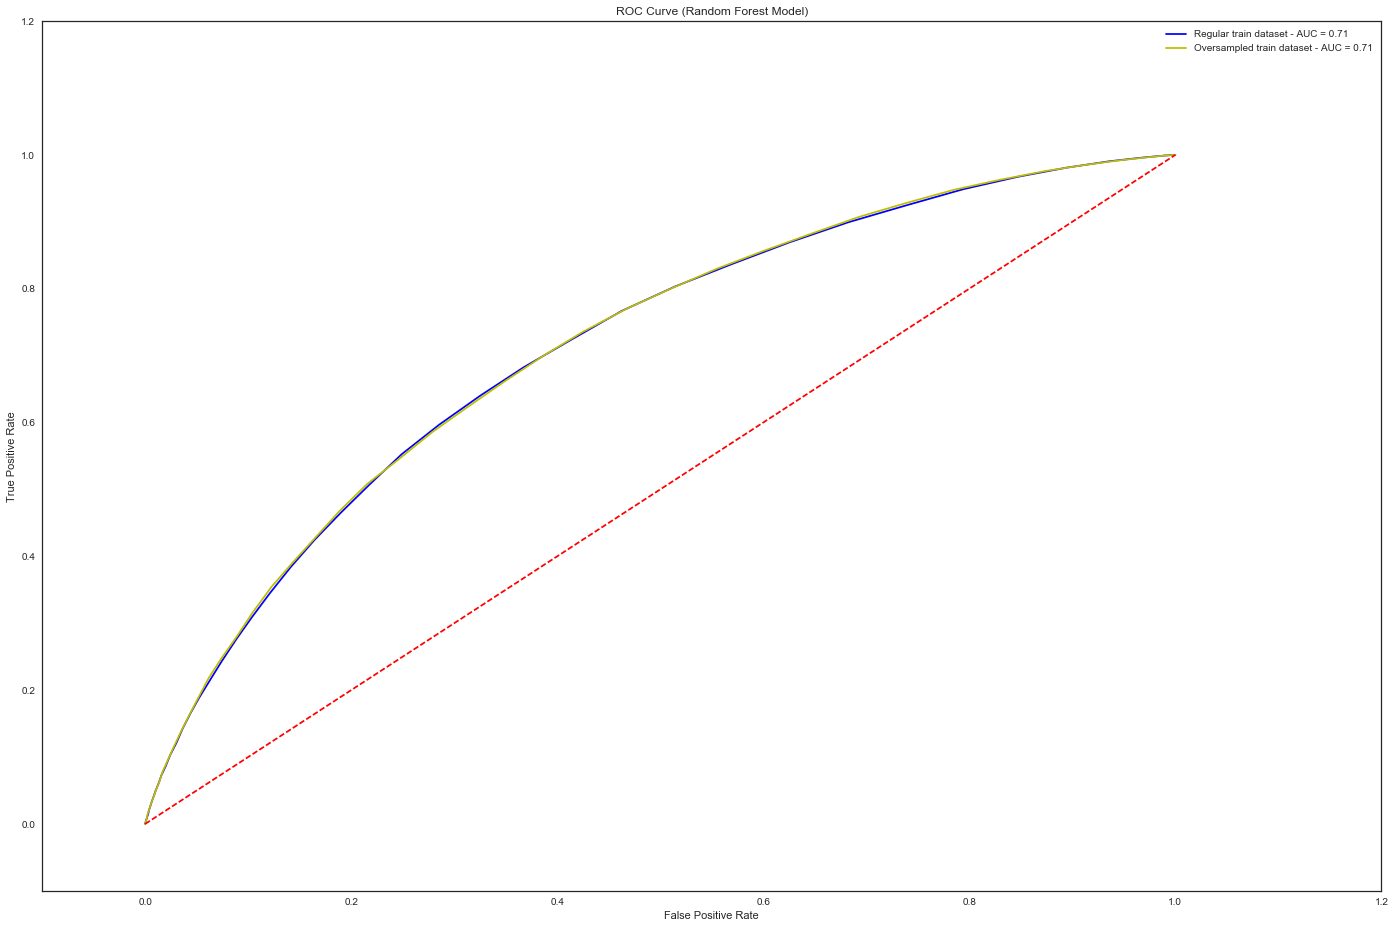

In [47]:
# ROC Curve
rf_fpr, rf_tpr, rf_threshold = roc_curve(np.array(test_loans.target),rf_est.predict_proba(test_loans.data)[:,1] )
rf_fpr_ovr, rf_tpr_ovr, rf_threshold_over = roc_curve(np.array(test_loans.target),rf_est_smpled.predict_proba(test_loans.data)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc_ovr = auc(rf_fpr_ovr, rf_tpr_ovr)
plt.title('ROC Curve (Random Forest Model)')
plt.plot(rf_fpr, rf_tpr, 'b', label='Regular train dataset - AUC = %0.2f'% rf_roc_auc)
plt.plot(rf_fpr_ovr, rf_tpr_ovr, 'y', label='Oversampled train dataset - AUC = %0.2f'% rf_roc_auc_ovr)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Oversampling doesn’t make much difference to the model in terms of the Sensitivity & Specificity

### 4.2.2 Feature Importance

The below chart shows the top 20 most important features as per the Random Forest model.

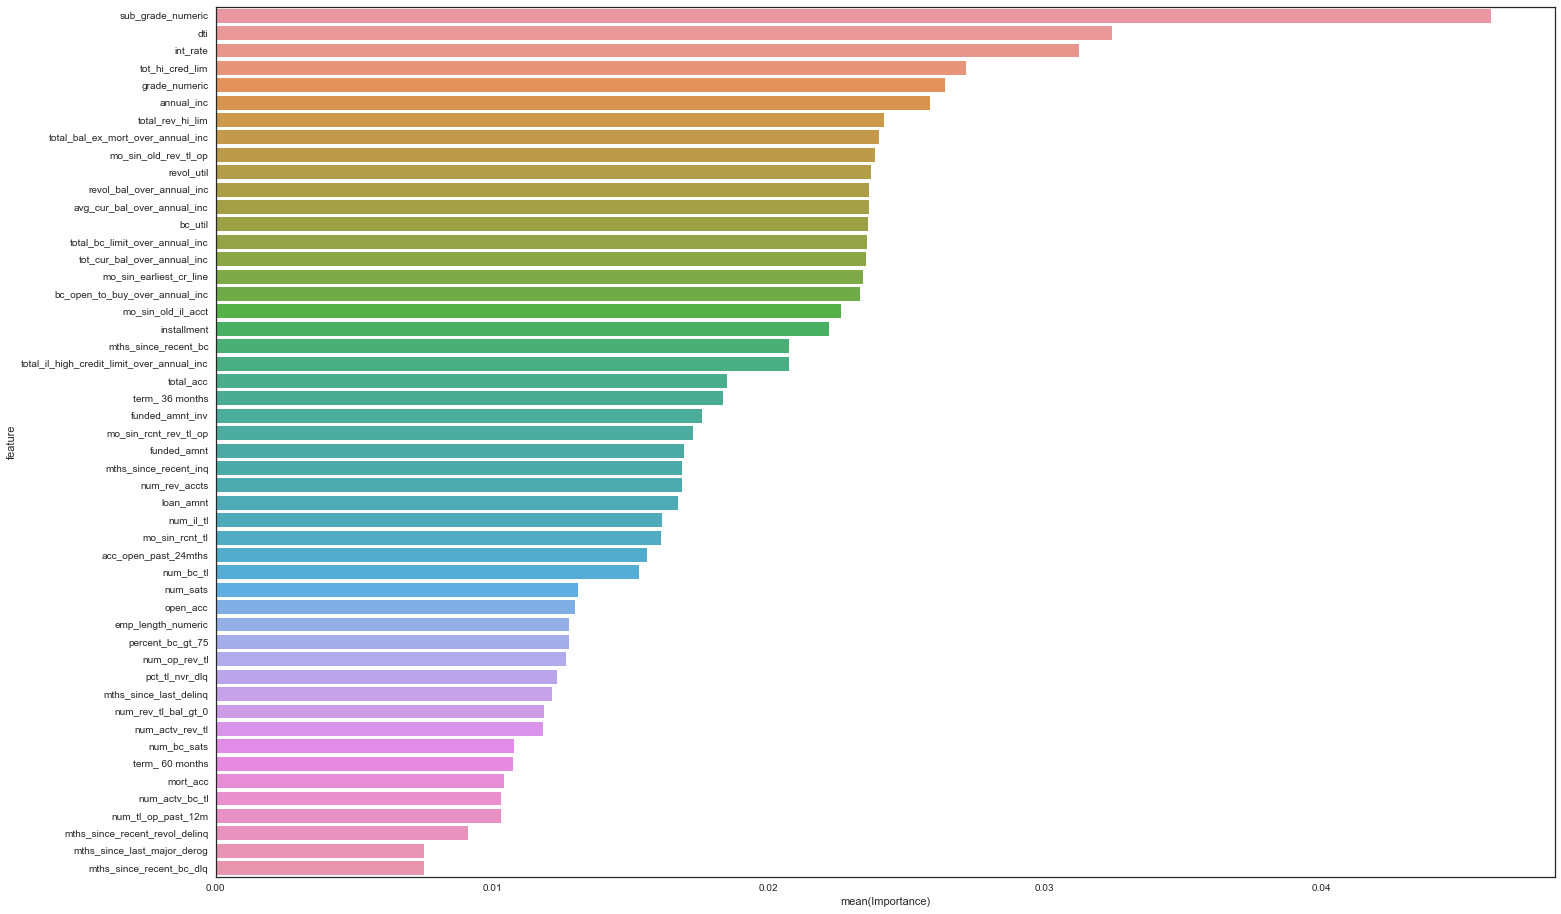

In [48]:
rf_importance = rf_est.feature_importances_
rf_importance = pd.DataFrame(rf_importance, index=train_loans.data.columns, 
                          columns=["Importance"])
rf_importance.sort_values('Importance', ascending = False, inplace=True)
rf_importance['feature'] = rf_importance.index
sns.barplot(y = 'feature', x = 'Importance', data= rf_importance.head(50) )
plt.savefig("RF-feature.png")

## 4.3 Light Gradient Boost Model

The Light GBM model is a high performance variant of Gradient Boost model which splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth-wise or level-wise. Here the parameter num_leaves determines the extent of growth of the trees. Max_depth parameter serves as a means to limit the tree from growing beyond  the defined level. Based on cross validation results, a Light GBM binary tree with 300 leaves and a low learning_rate of 0.05 was trained. The evaluation metric for the model was set to ‘AUC’ and ‘F1_Weighted’ scores so that the class imbalance is addressed.
We noticed that the Light GBM model indeed performs faster in comparison to XG Boost and gives comparable scores as well.


In [49]:
# Fit Light GBM on the regular train_loans, parameter values selected as per the tuning results from next section
train_lgb = lgb.Dataset(train_loans.data, label=train_loans.target)
param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.05, 'max_bin': 100, 'min_data_in_leaf' : 300}
num_round=500

lgbm=lgb.train(param,train_lgb,num_round)

In [50]:
#Score the model and record the score
score = score_the_model(train_loans, test_loans, lgbm, model_key= 'Light GBM', use_PredictProba=False)
allmodelscores = allmodelscores.append([score], ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
2,0.742971,0.768419,0.773039,0.784506,0.756491,0.769141,0.418322,0.518029,0.350801,0.859014,0.820726,0.90105,Light GBM,0.466543,0.507788


In [51]:
# Fit and score Light GBM on the over sampled training dataset.
# Fit Light GBM on the regular train_loans, parameter values selected as per the tuning results from next section
smpled_train_lgb = lgb.Dataset(sampled_lr_loans.data, label=sampled_lr_loans.target)
param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.05, 'max_bin': 100, 'min_data_in_leaf' : 300}
num_round=500

lgbm_smpled=lgb.train(param,smpled_train_lgb,num_round)
score = score_the_model(sampled_lr_loans, test_loans, lgbm_smpled, model_key= 'Light GBM with Oversampling', use_PredictProba=False)
allmodelscores = allmodelscores.append([score], ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
3,0.740585,0.926124,0.773226,0.85596,0.755141,0.855577,0.410573,0.51929,0.339497,0.859605,0.818776,0.904721,Light GBM with Oversampling,0.462843,0.94421


### 4.3.1 ROC Curve

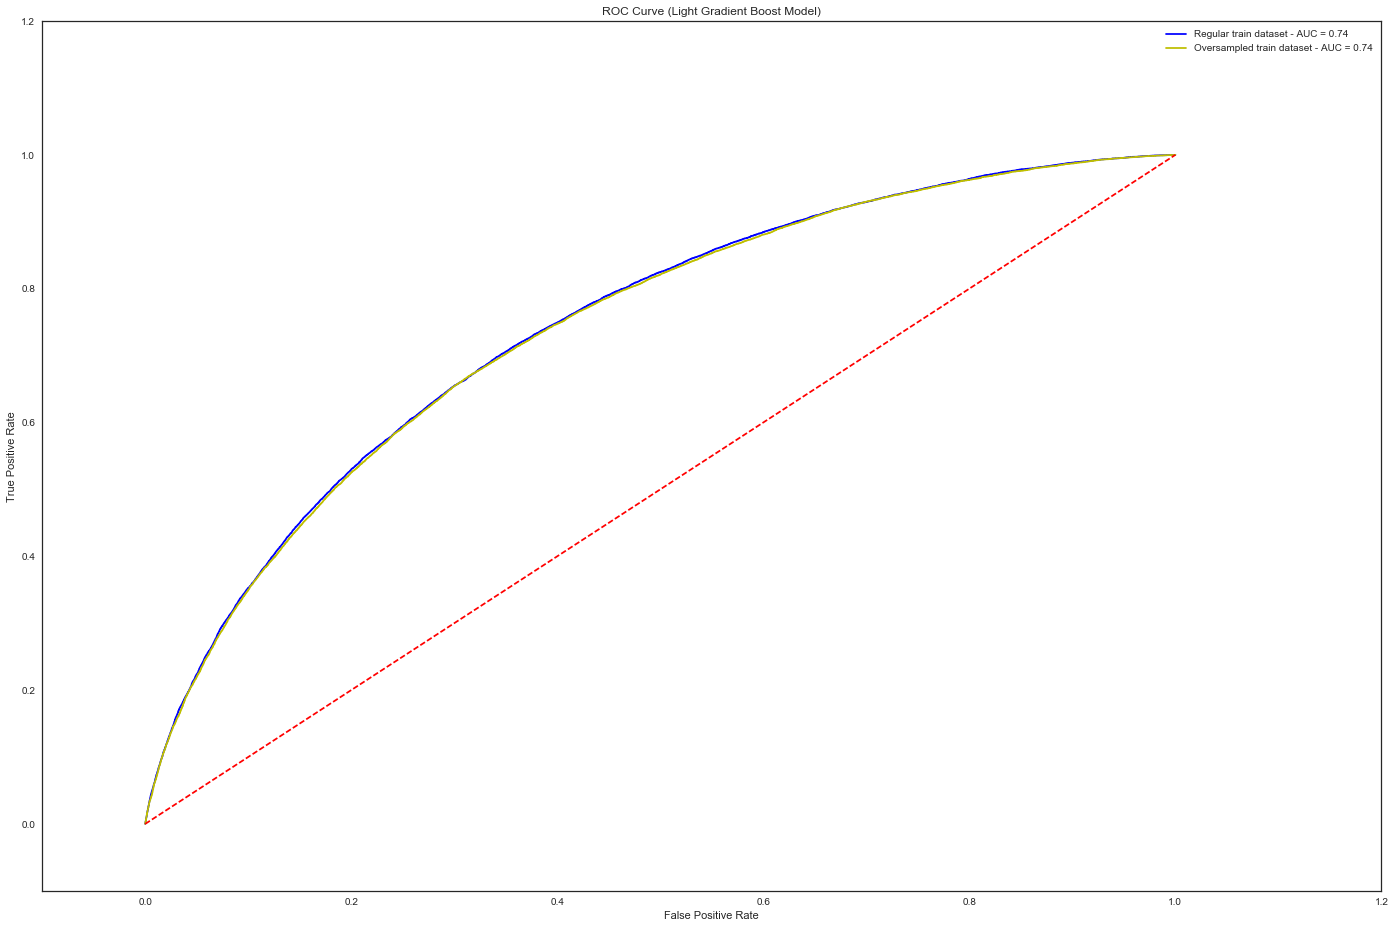

In [52]:
# ROC Curve
lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(np.array(test_loans.target),lgbm.predict(test_loans.data) )
lgbm_fpr_ovr, lgbm_tpr_ovr, lgbm_threshold_over = roc_curve(np.array(test_loans.target),lgbm_smpled.predict(test_loans.data))
lgbm_roc_auc = auc(lgbm_fpr, lgbm_tpr)
lgbm_roc_auc_ovr = auc(lgbm_fpr_ovr, lgbm_tpr_ovr)
plt.title('ROC Curve (Light Gradient Boost Model)')
plt.plot(lgbm_fpr, lgbm_tpr, 'b', label='Regular train dataset - AUC = %0.2f'% lgbm_roc_auc)
plt.plot(lgbm_fpr_ovr, lgbm_tpr_ovr, 'y', label='Oversampled train dataset - AUC = %0.2f'% lgbm_roc_auc_ovr)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Oversampling doesn’t make much difference to the model in terms of the Sensitivity & Specificity


### 4.3.3	Feature Importances

The below chart shows the top 20 most important features as per the Light GBM model.


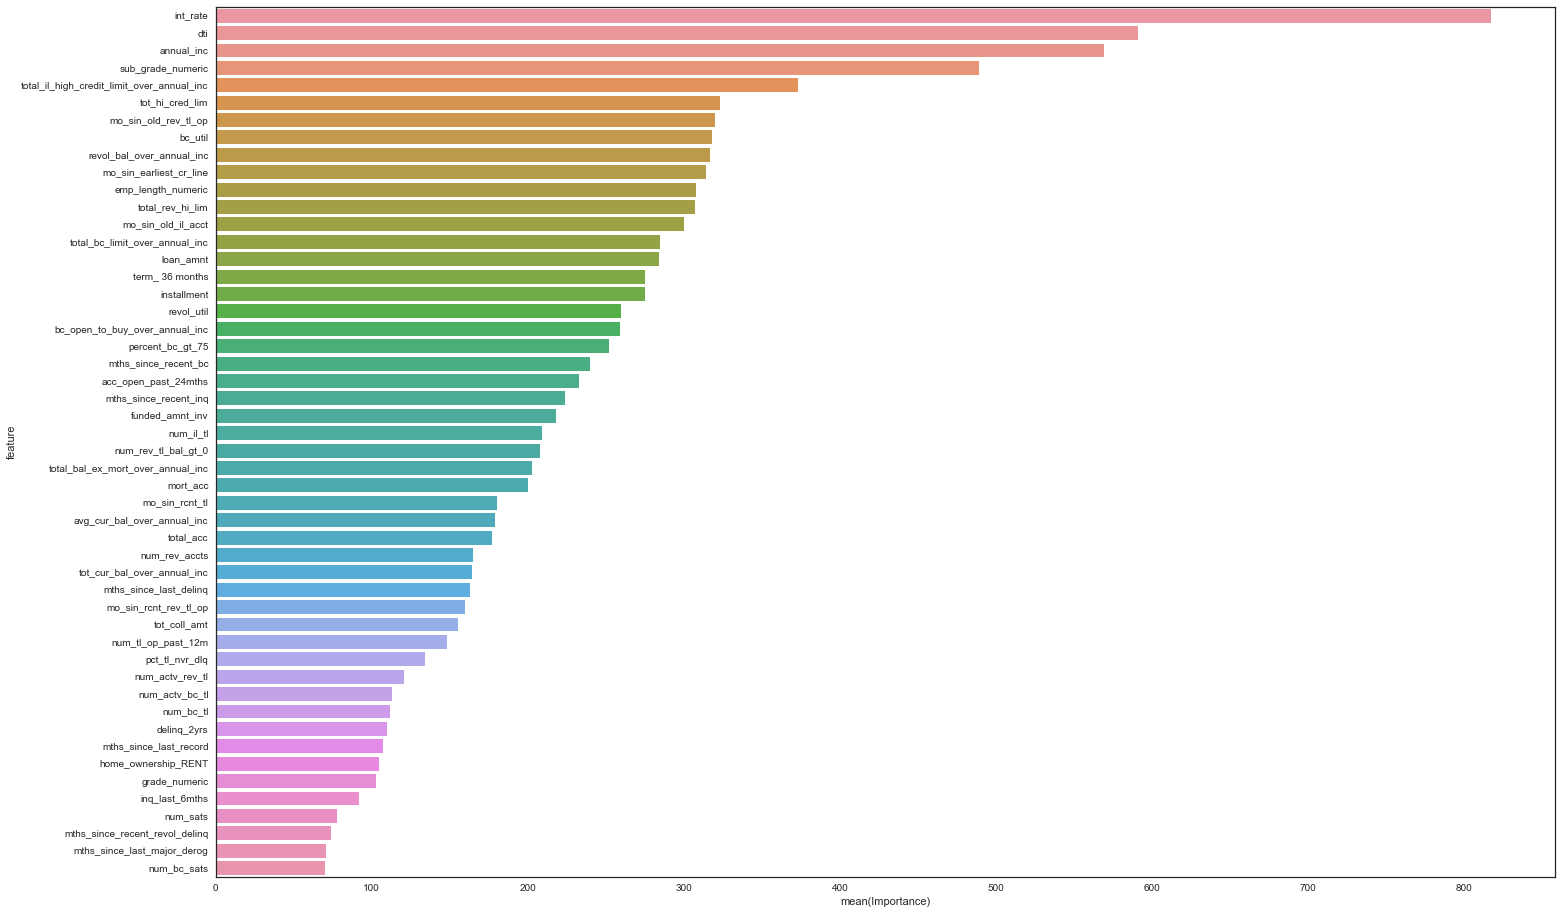

In [53]:
lgbm_importance = lgbm.feature_importance()
lgbm_importance = pd.DataFrame(lgbm_importance, index=train_loans.data.columns, 
                          columns=["Importance"])
lgbm_importance.sort_values('Importance', ascending = False, inplace=True)
lgbm_importance['feature'] = lgbm_importance.index
sns.barplot(y = 'feature', x = 'Importance', data= lgbm_importance.head(50) )

## 4.4 XGBoost

The XGBM model was implemented with the ‘gbtree’ booster and tuned parameters from cross validation. A learning_rate parameter value of 0.15 and 300 trees gave better results with the full dataset. The model was trained using AUC as the evaluation metric.

Below is a summary of the results & a plot of the ROC curve for the models trained using the regular dataset and the oversampled data set


In [54]:
#Parameters selected from cross validation in the next section
xg_est = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=1, max_depth=5, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8,  scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=300)
xg_est.fit(train_loans.data, train_loans.target, eval_metric = 'auc')
allmodelscores = allmodelscores.append(score_the_model(train_loans, test_loans, xg_est, model_key='XG Boost'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
4,0.742511,0.783176,0.773401,0.79227,0.757735,0.778282,0.423825,0.51881,0.358237,0.858968,0.822125,0.899267,XG Boost,0.46583,0.536686


In [55]:
# XGBoost with over sampled training set
xg_est_smpled = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=1, max_depth=5, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8,  scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=300)
xg_est_smpled.fit(sampled_lr_loans.data, sampled_lr_loans.target, eval_metric = 'auc')
allmodelscores = allmodelscores.append(score_the_model(sampled_lr_loans, test_loans, xg_est_smpled, model_key='XG Boost with OverSampling'), ignore_index=True)
allmodelscores.tail(1)

-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
5,0.741705,0.932262,0.771402,0.861625,0.755891,0.861351,0.42031,0.512505,0.356228,0.85763,0.821342,0.897272,XG Boost with OverSampling,0.462982,0.948381


Here we see that the performance metrics on test set remains the same between the models. The oversampled model has trained better, but doesn’t really translate to results on the test set. 

### 4.4.1 ROC Curve

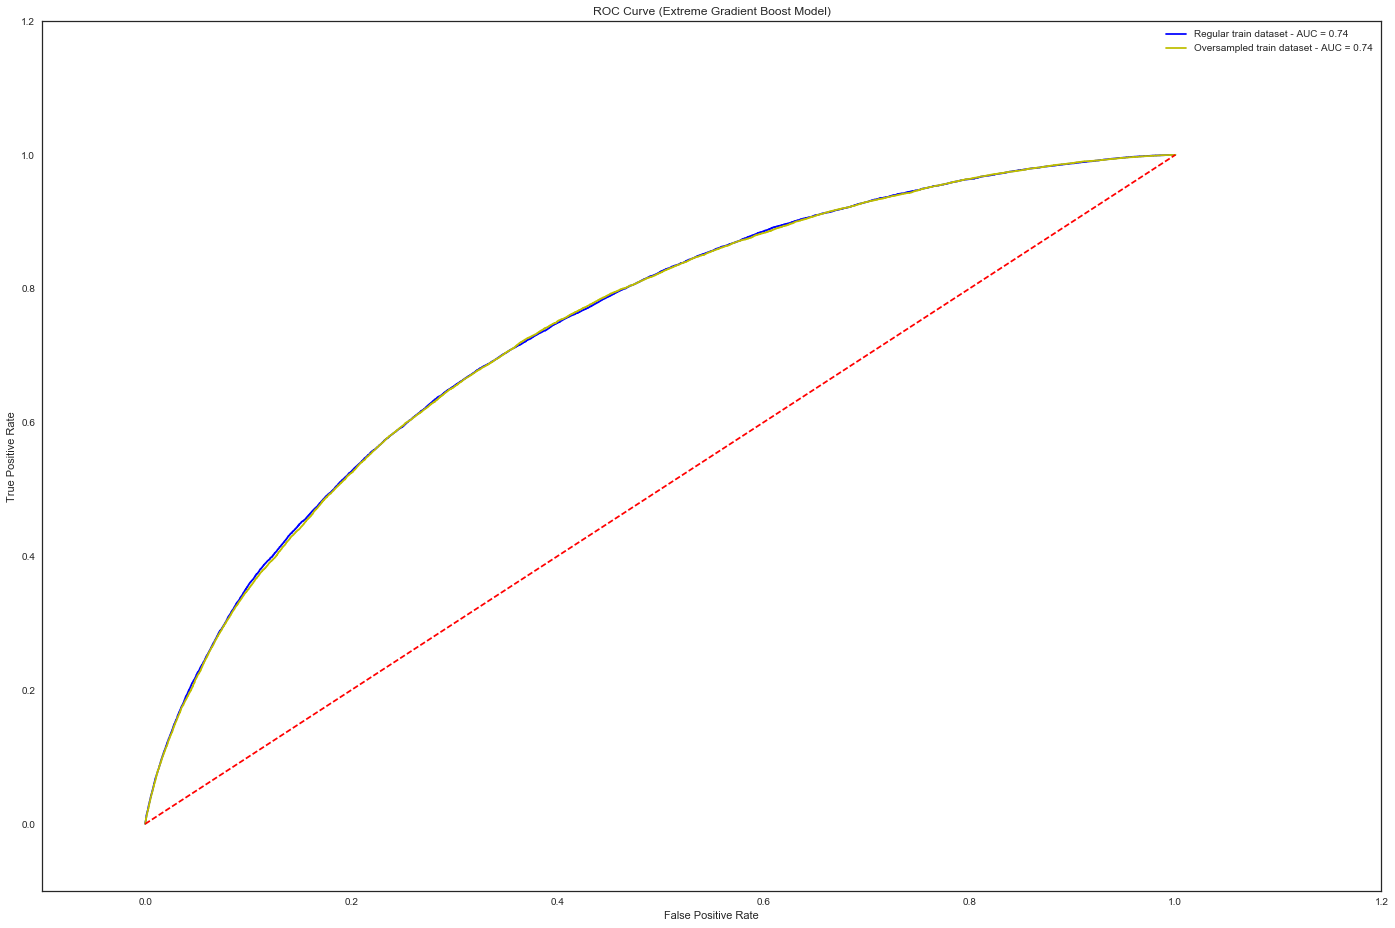

In [56]:
# ROC Curve
xg_fpr, xg_tpr, xg_threshold = roc_curve(np.array(test_loans.target),xg_est.predict_proba(test_loans.data)[:,1] )
xg_fpr_ovr, xg_tpr_ovr, xg_threshold_over = roc_curve(np.array(test_loans.target),xg_est_smpled.predict_proba(test_loans.data)[:,1])
xg_roc_auc = auc(xg_fpr, xg_tpr)
xg_roc_auc_ovr = auc(xg_fpr_ovr, xg_tpr_ovr)
plt.title('ROC Curve (Extreme Gradient Boost Model)')
plt.plot(xg_fpr, xg_tpr, 'b', label='Regular train dataset - AUC = %0.2f'% xg_roc_auc)
plt.plot(xg_fpr_ovr, xg_tpr_ovr, 'y', label='Oversampled train dataset - AUC = %0.2f'% xg_roc_auc_ovr)
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Oversampling doesn’t make much difference to the model in terms of the Sensitivity & Specificity
### 4.4.3	Feature Importances
The below chart shows the top 20 most important features as per the XG Boost Model.


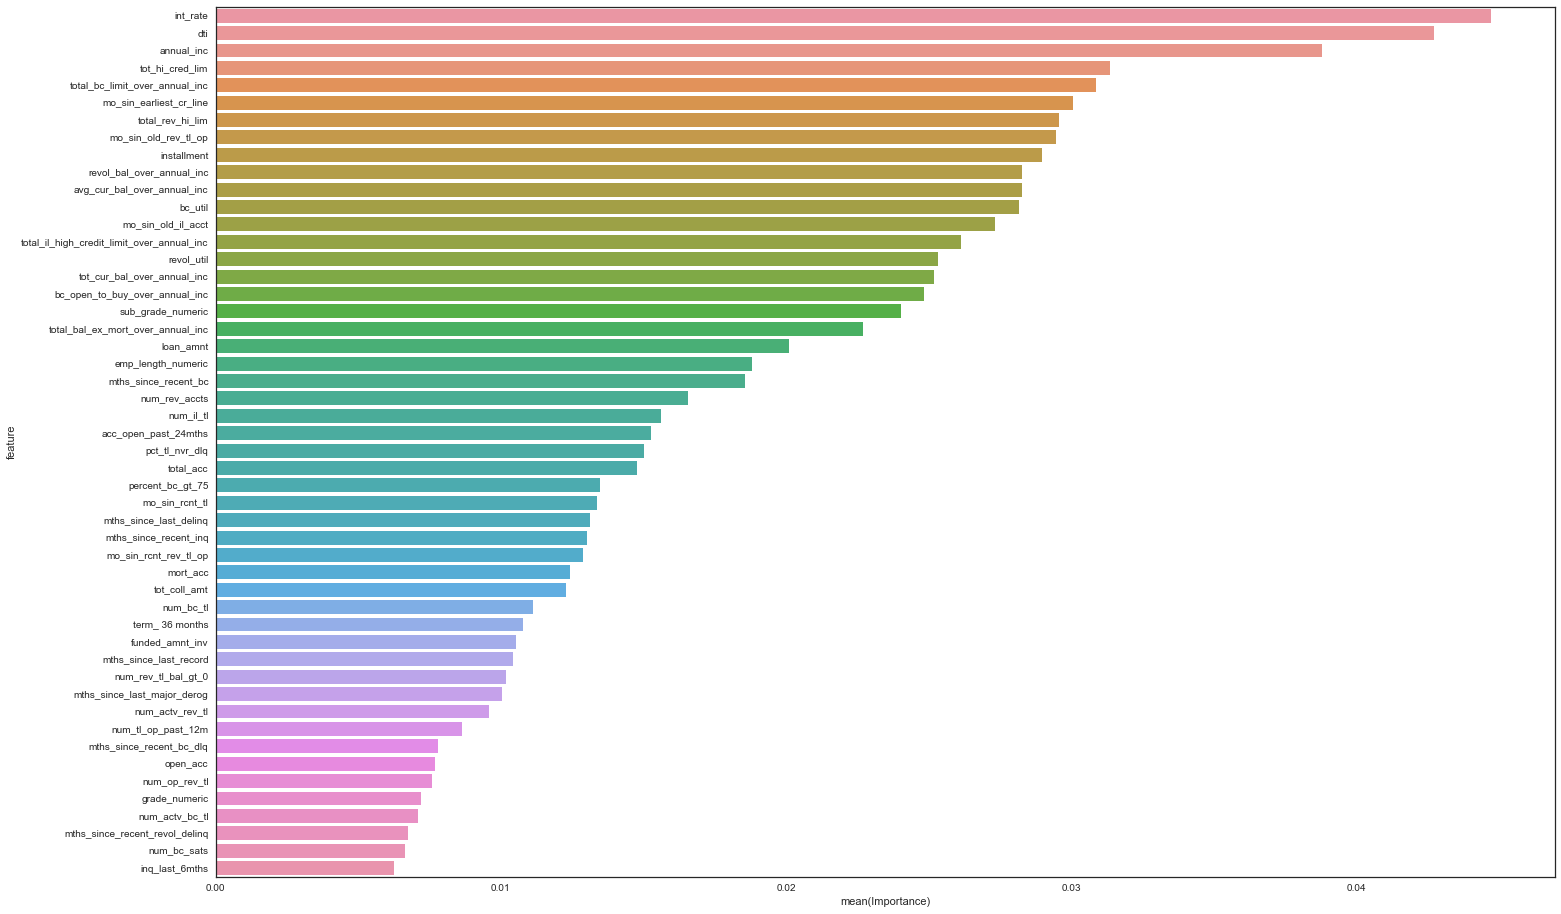

In [57]:
xg_importance = xg_est.feature_importances_
xg_importance = pd.DataFrame(xg_importance, index=train_loans.data.columns, 
                          columns=["Importance"])
xg_importance.sort_values('Importance', ascending = False, inplace=True)
xg_importance['feature'] = xg_importance.index
sns.barplot(y = 'feature', x = 'Importance', data= xg_importance.head(50) )
plt.savefig("xg-feature.png")

## 4.5 Voting Ensemble

A Voting Ensemble was implemented using the above three models and the performance of the results from this ensemble model was recorded. Two voting models were implemented with two types of voting – 
1.	a ‘soft’ voting which will return an average of the predicted probabilities 
2.	a ‘soft argmax’ voting which will return the maximum value of predicted probabilities for the positive (Bad) class from among the three classifiers.

Note: sklearn’s VotingClassifier ensemble could not be used here as the Light GBM model does not follow the sklearn Classifier methods and a custom implementation was needed. Also, that allowed for the implementation of the ‘Argmax’ voting which is not supported in the sklearn VotingClassifier

Below is a summary of the results & a plot of the ROC curve for the models trained using the regular dataset and the oversampled data set.


In [58]:
# A voting ensemble that will return a 'soft' voting - average of the predicted probabilities of each classifier. 
# Note: Not using sklearn's VotingClassifier as the Light GBM classifier that's used here is not a sklearn classifier, so the methods 
# do not generalize. So a custom implementation is done here.
rf_proba = rf_est.predict_proba(test_loans.data)[:,1]
lgbm_proba = lgbm.predict(test_loans.data)
xg_proba = xg_est.predict_proba(test_loans.data)[:,1]
final_proba_avg = (lgbm_proba + xg_proba + rf_proba) / 3
final_proba_max = np.max( np.array([ lgbm_proba, xg_proba, rf_proba ]), axis=0 )

final_predictions_avg = np.array([0 if p < 0.4 else 1 for p in final_proba_avg])
final_predictions_max = np.array([0 if p < 0.4 else 1 for p in final_proba_max])

In [59]:
tr_accuracy = '-'
te_accuracy = accuracy_score(np.array(test_loans.target), final_predictions_avg)
    
tr_auc = '-'
te_auc = roc_auc_score(np.array(test_loans.target), np.array(final_proba_avg), average = 'weighted')
    
tr_prec = '-'
te_prec = average_precision_score(np.array(test_loans.target), np.array(final_proba_avg), average = 'weighted')
    
tr_f1 = '-'
te_f1 = f1_score(np.array(test_loans.target), np.array(final_predictions_avg), average = 'weighted')

prec, recall, f1, support = precision_recall_fscore_support(np.array(test_loans.target), np.array(final_predictions_avg))
te_0_prec, te_1_prec = prec[0], prec[1]
te_0_rec, te_1_rec = recall[0], recall[1]
te_0_f1, te_1_f1 = f1[0], f1[1]
    
scores = pd.Series(['Voting Ensemble - Average voting',tr_accuracy,te_accuracy,tr_auc,te_auc,tr_prec,te_prec,tr_f1,te_f1, te_0_prec,te_1_prec,
                         te_0_rec, te_1_rec,te_0_f1, te_1_f1], ['Model','Accuracy (Train)', 'Accuracy (Test)', 'AUC (Train)', 'AUC (Test)',
                                        'Precision (Train)', 'Precision (Test)','F1-Weighted (Train)', 'F1-Weighted (Test)',
                                        'Label-Good Precision (Test)','Label-Bad Precision (Test)', 'Label-Good Recall (Test)',
                                        'Label-Bad Recall (Test)','Label-Good F1 (Test)','Label-Bad F1 (Test)'  ] )
allmodelscores = allmodelscores.append(scores, ignore_index=True)
allmodelscores.tail(1)

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
6,0.740908,-,0.773822,-,0.753373,-,0.399441,0.522449,0.323318,0.860675,0.816099,0.910402,Voting Ensemble - Average voting,0.463047,-


In [60]:
tr_accuracy = '-'
te_accuracy = accuracy_score(np.array(test_loans.target), final_predictions_max)
    
tr_auc = '-'
te_auc = roc_auc_score(np.array(test_loans.target), np.array(final_proba_max), average = 'weighted')
    
tr_prec = '-'
te_prec = average_precision_score(np.array(test_loans.target), np.array(final_proba_max), average = 'weighted')
    
tr_f1 = '-'
te_f1 = f1_score(np.array(test_loans.target), np.array(final_predictions_max), average = 'weighted')

prec, recall, f1, support = precision_recall_fscore_support(np.array(test_loans.target), np.array(final_predictions_max))
te_0_prec, te_1_prec = prec[0], prec[1]
te_0_rec, te_1_rec = recall[0], recall[1]
te_0_f1, te_1_f1 = f1[0], f1[1]
    
scores = pd.Series(['Voting Ensemble - ArgMax voting',tr_accuracy,te_accuracy,tr_auc,te_auc,tr_prec,te_prec,tr_f1,te_f1, te_0_prec,te_1_prec,
                         te_0_rec, te_1_rec,te_0_f1, te_1_f1], ['Model','Accuracy (Train)', 'Accuracy (Test)', 'AUC (Train)', 'AUC (Test)',
                                        'Precision (Train)', 'Precision (Test)','F1-Weighted (Train)', 'F1-Weighted (Test)',
                                        'Label-Good Precision (Test)','Label-Bad Precision (Test)', 'Label-Good Recall (Test)',
                                        'Label-Bad Recall (Test)','Label-Good F1 (Test)','Label-Bad F1 (Test)'  ] )
allmodelscores = allmodelscores.append(scores, ignore_index=True)
allmodelscores.tail(2)

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
6,0.740908,-,0.773822,-,0.753373,-,0.399441,0.522449,0.323318,0.860675,0.816099,0.910402,Voting Ensemble - Average voting,0.463047,-
7,0.736697,-,0.759421,-,0.753913,-,0.450061,0.480625,0.423152,0.846033,0.831234,0.861369,Voting Ensemble - ArgMax voting,0.460291,-


With the   Argmax voting, the recall rate for Bad class gets a boost, but at the cost of the precision

### 4.5.1 ROC Curve

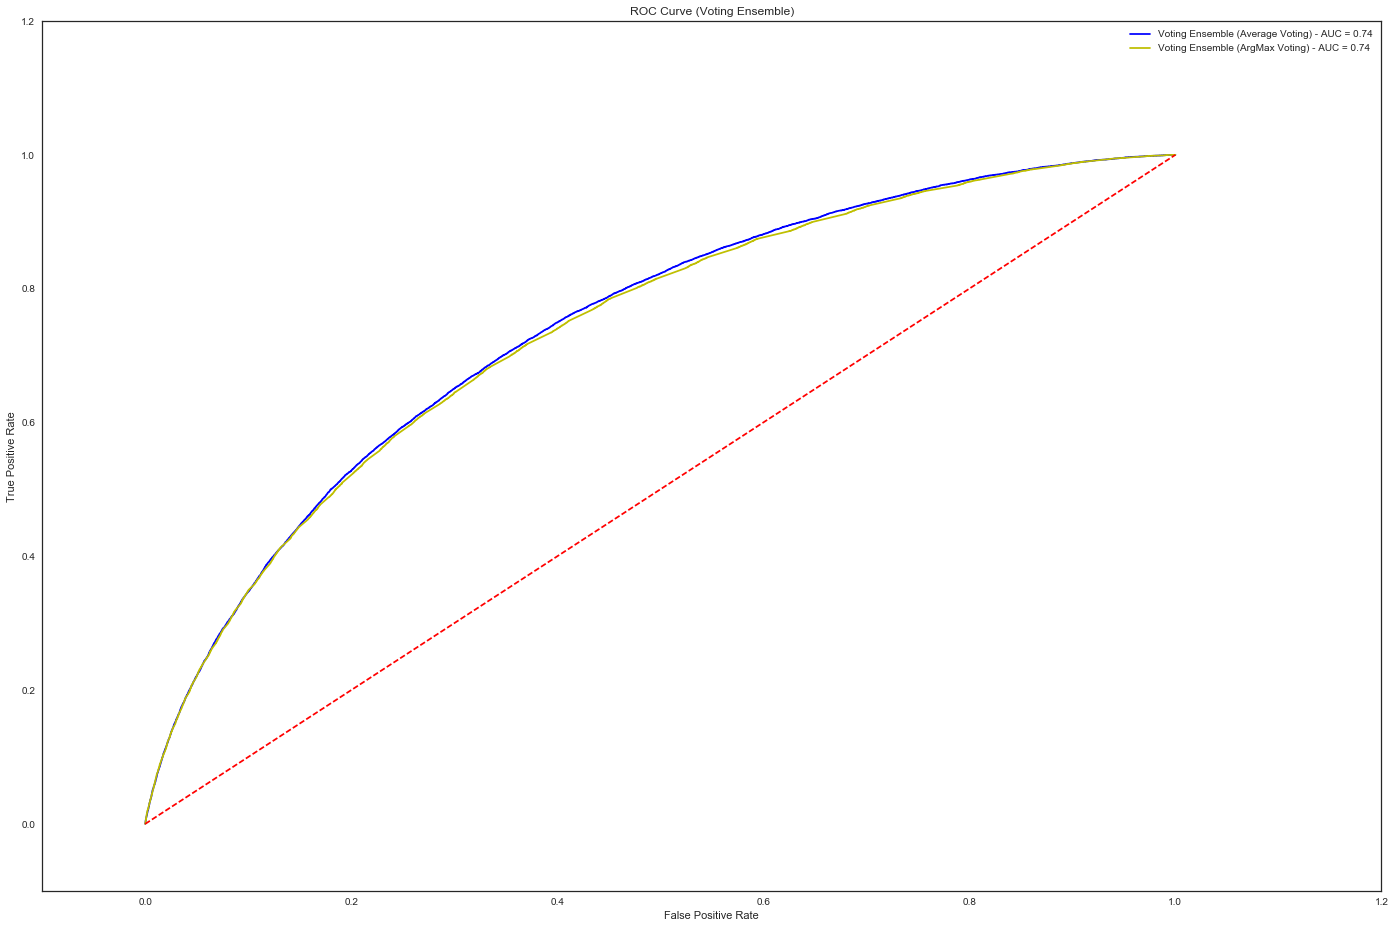

In [61]:
# ROC Curve
ve_fpr, ve_tpr, ve_threshold = roc_curve(np.array(test_loans.target),final_proba_avg )
vem_fpr, vem_tpr, vem_threshold = roc_curve(np.array(test_loans.target),final_proba_max )
ve_roc_auc = auc(ve_fpr, ve_tpr)
vem_roc_auc = auc(vem_fpr, vem_tpr)

plt.title('ROC Curve (Voting Ensemble)')
plt.plot(ve_fpr, ve_tpr, 'b', label='Voting Ensemble (Average Voting) - AUC = %0.2f'% ve_roc_auc)
plt.plot(vem_fpr, vem_tpr, 'y', label='Voting Ensemble (ArgMax Voting) - AUC = %0.2f'% vem_roc_auc)

plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4.6 Model Comparison

Below is a summary of all models that we saw in detail above

In [62]:
#See the results summary from all models
allmodelscores

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.713328,1,0.763688,0.999991,0.738409,0.999991,0.352248,0.486116,0.276190,0.855482,0.805964,0.911484,Random Forest,0.420832,1
1,0.714428,1,0.748457,0.999983,0.741693,0.999983,0.419195,0.452854,0.390192,0.839465,0.822566,0.857073,Random Forest with Oversampling,0.422368,1
2,0.742971,0.768419,0.773039,0.784506,0.756491,0.769141,0.418322,0.518029,0.350801,0.859014,0.820726,0.901050,Light GBM,0.466543,0.507788
3,0.740585,0.926124,0.773226,0.85596,0.755141,0.855577,0.410573,0.519290,0.339497,0.859605,0.818776,0.904721,Light GBM with Oversampling,0.462843,0.94421
4,0.742511,0.783176,0.773401,0.79227,0.757735,0.778282,0.423825,0.518810,0.358237,0.858968,0.822125,0.899267,XG Boost,0.465830,0.536686
5,0.741705,0.932262,0.771402,0.861625,0.755891,0.861351,0.420310,0.512505,0.356228,0.857630,0.821342,0.897272,XG Boost with OverSampling,0.462982,0.948381
6,0.740908,-,0.773822,-,0.753373,-,0.399441,0.522449,0.323318,0.860675,0.816099,0.910402,Voting Ensemble - Average voting,0.463047,-
7,0.736697,-,0.759421,-,0.753913,-,0.450061,0.480625,0.423152,0.846033,0.831234,0.861369,Voting Ensemble - ArgMax voting,0.460291,-


In terms of AUC score, we’ve seen above that all the models, including the Voting Ensemble models gave the same AUC score – 0.72 or 0.74. So we will focus on the Precision – Recall values for the Bad loan class for model comparison

### 4.6.1	Features
Let’s compare the top 15 features identified by the three algorithms (Random Forest, Light GBM, XG Boost) as below.


C:\Users\Anu\Anaconda3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Anu\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


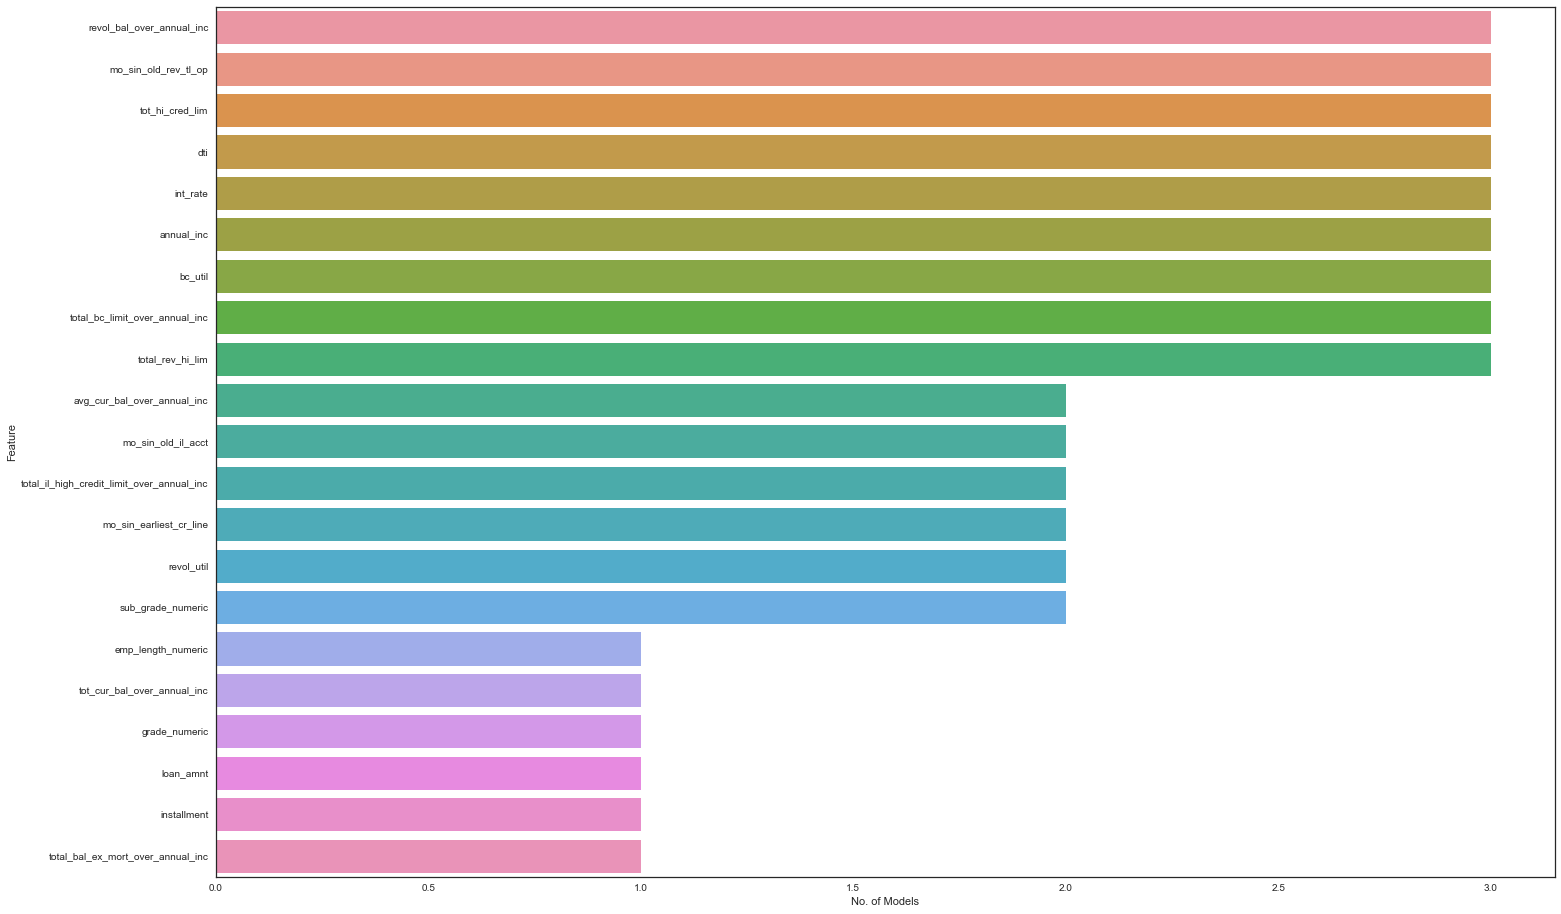

In [63]:
# Compare top 15 features across the three models
rf_top = rf_importance.head(15)
rf_top.loc[:,'Model'] = 'Random Forest'
xg_top = xg_importance.head(15)
xg_top.loc[:,'Model'] = 'XG Boost'
lgbm_top = lgbm_importance.head(15)
lgbm_top.loc[:,'Model'] = 'Light GBM'
frames = [rf_top, xg_top, lgbm_top]
top_features = pd.concat(frames, axis = 0)
#top_features = 
top = pd.DataFrame(top_features.feature.value_counts())
top['feature_name'] = top.index
ax = sns.barplot(x = 'feature', y = 'feature_name' ,data = top)
ax.set_xlabel('No. of Models')
ax.set_ylabel('Feature')

We can see from above that 10 of the top 15 features are common across the three models. So we can safely conclude that these features are indeed most significant in indicating whether a loan will default.

At the same time, the drawback is that all the models have caught on to the same patterns and features and that's the reason why the Voting Ensemble doesn't have a significant performance improvement over the individual models

### 4.6.2	Precision – Recall for ‘Bad’ loans

The below is a plot of Precision & Recall values for the ‘Bad’ class loans in all the models. 
Keeping in mind that our goal is to identify as many defaulter loans as possible and with as much precision as we can, let’s see how each model performs.


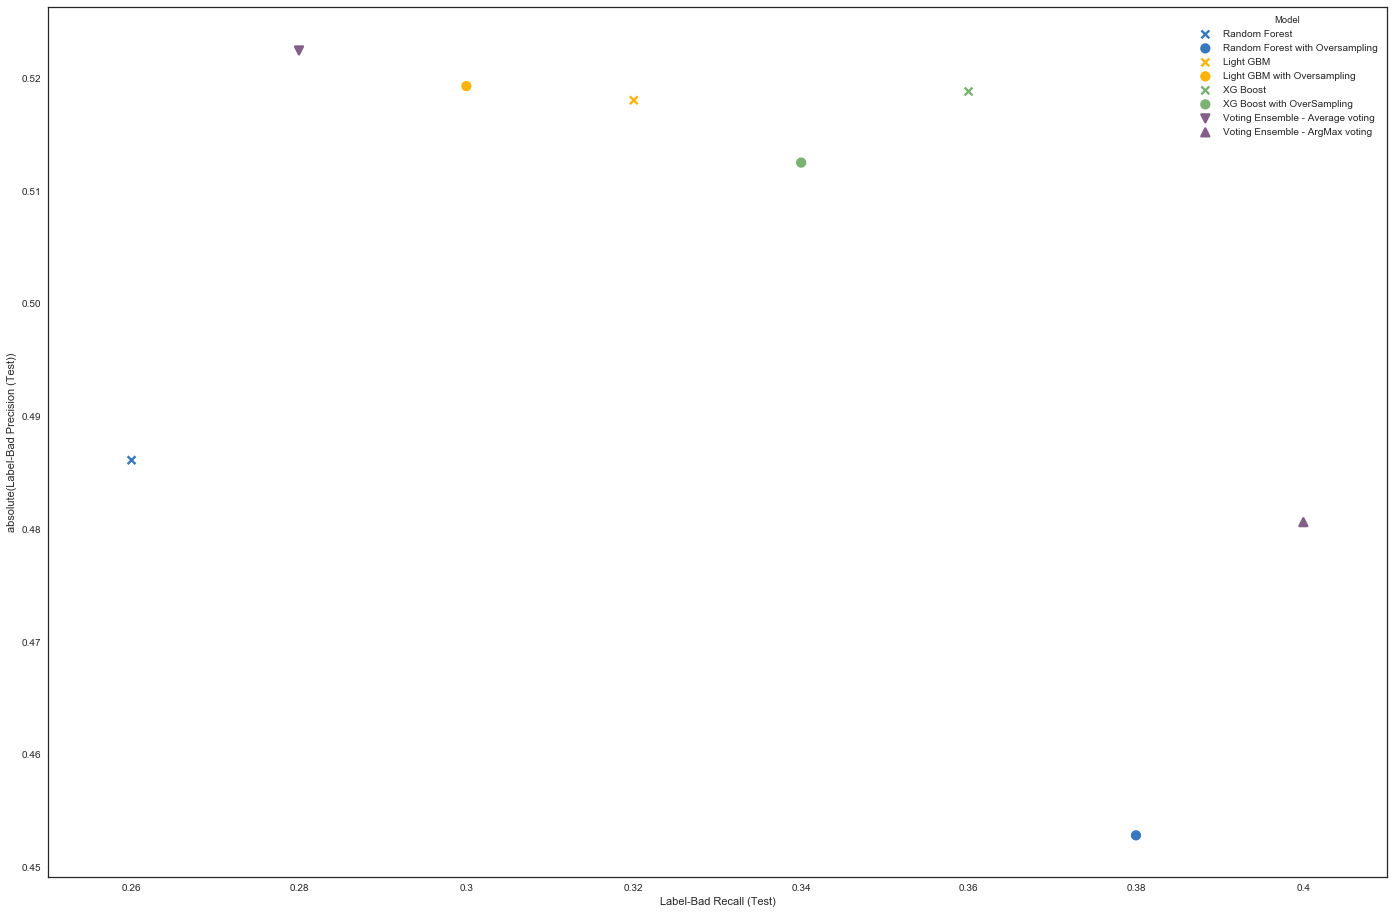

In [64]:
# Plot Precision & Recall for 'Bad' loans from all models
colors = ["windows blue", "windows blue", "amber", "amber", "faded green","faded green", "dusty purple", "dusty purple"]
ax = sns.pointplot('Label-Bad Recall (Test)', 'Label-Bad Precision (Test)', hue = 'Model', data = allmodelscores, 
                   estimator = np.abs, markers = ['x', 'o', 'x', 'o', 'x', 'o', 'v', '^'], 
                   palette = sns.xkcd_palette(colors))
ax.set_xticklabels(np.arange(0.26, 0.52, 0.02))
#ax.set_xticks(np.arange(0, 0.52, 0.02))
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 1)

Voting Ensemble with Average voting gives the most precision, but the recall drops from around 0.42 to 0.28 with an increase in precision only from 0.48 to 0.52. 
Out of the remaining, the top two options to consider are XG Boost & Voting Ensemble with Argmax voting. If the priority is to reduce default risk as much as possible, we would go with the Voting Ensemble with Argmax voting as it gives more recall rate.



### 4.6.3	Model Evaluation in a hypothetical funding scenario

Let’s evaluate the model in terms of a hypothetical funding scenario and see how much the investor would have gained / lost if he relied on this loan default prediction for his investment. We’ll consider two of the models that we recommended based on the Precision & Recall of ‘Bad’ class loans and the 85,552 loans in the Test dataset as the targeted loans for funding.

The actual observed Return on Investment for each loan has been calculated as (Total Repaid amount – Total funded amount) / Total funded amount. This ROI rate is used for calculating the total return for an investor in each of the hypothetical scenario.


Scenario 1 :  An investor has $300,000 and invests them equally in all the 85,552 loans from the Test set. 

In [66]:
#assuming the following.
# a) the return on investment (ROI) on each loan has been pre-calculated based on the actual repayment amount and funded amount. 
# b) Total ROI is sum of (ROI * amount invested in the loan) for all invested loans
# c) Total Invested amount is $300,000 and equally divided into each of the invested loan

# Scenario 1 - Loan default prediction model is not used and the investment is made equally on all loans in the test dataset
total_investment = 300000
inv_per_loan = total_investment / len(test_loans) 
total_roi = np.sum(loans.iloc[test_loans.index].roi_inv * inv_per_loan)
print ("Investing $%d in %d loans" %(total_investment, len(test_loans)))
print ("%d loans defaulted!" %len(test_loans[test_loans.target ==1]))
print( "ROI is $%d" %(total_roi))

Investing $300000 in 85552 loans
19903 loans defaulted!
ROI is $-1


Scenario 2 :  An investor has $300,000 and invests them equally in 71,809 loans predicted to be ‘Good’ by the XG Boost model out of the 85,552 loans from the Test set.

In [68]:
# Scenario 2 - The XG Boost prediction model is used and the investment is made equally on all loan predicted to be 'Good' in the
# test dataset
xg_proba = xg_est.predict_proba(test_loans.data)[:,1]
xg_predictions = np.array([0 if p < 0.4 else 1 for p in xg_proba])

#Investing only in loans predicted to be 'Good'
xg_inv_loans = test_loans[xg_predictions == 0]
total_investment = 300000
inv_per_loan = total_investment / len(xg_inv_loans)

total_roi = np.sum(loans.iloc[xg_inv_loans.index].roi_inv * inv_per_loan)

print ("Investing $%d in %d loans" %(total_investment, len(xg_inv_loans)))
print ("%d loans defaulted!" %len(xg_inv_loans[xg_inv_loans.target ==1]))
print( "ROI is $%d" %(total_roi))

#Calculating potential revenue loss for LC
xg_not_inv_good_loans = test_loans[np.logical_and(xg_predictions == 1 , test_loans.target == 0)]

#total_rev_loss = np.sum(loans.iloc[xg_not_inv_good_loans.index].roi_inv * xg_not_inv_good_loans.loan_amnt)
print ("%d loans did not default!" %len(xg_not_inv_good_loans))
#print( "Potential total revenue loss is $%d" %(total_rev_loss))

Investing $300000 in 71809 loans
12773 loans defaulted!
ROI is $11142
6613 loans did not default!


Scenario 3 :  An investor has $300,000 and invests them equally in 68,045 loans predicted to be ‘Good’ by the Voting Ensemble by Argmax voting model out of the 85,552 loans from the Test set. 

In [70]:
# Scenario 3 - The Voting Ensemble with max voting prediction model is used and the investment is made equally on all 
#loan predicted to be 'Good' in the test dataset


#Investing only in loans predicted to be 'Good'
ve_inv_loans = test_loans[final_predictions_max == 0]
total_investment = 300000
inv_per_loan = total_investment / len(ve_inv_loans)

total_roi = np.sum(loans.iloc[ve_inv_loans.index].roi_inv * inv_per_loan)

print ("Investing $%d in %d loans" %(total_investment, len(ve_inv_loans)))
print ("%d loans defaulted!" %len(ve_inv_loans[ve_inv_loans.target ==1]))
print( "ROI is $%d" %(total_roi))

#Calculating potential revenue loss for LC
#ve_not_inv_good_loans = test_loans[np.logical_and(final_predictions_max == 1, test_loans.target == 0)]


#total_rev_loss = np.sum(loans.iloc[ve_not_inv_good_loans.index].roi_inv * ve_not_inv_good_loans.loan_amnt)
#print ("%d loans did not default!" %len(ve_not_inv_loans[ve_not_inv_loans.target ==0]))
#print( "Potential total revenue loss is $%d" %(total_rev_loss))

Investing $300000 in 68029 loans
11481 loans defaulted!
ROI is $12443


We can clearly see that we can better the ROI by using the loan default prediction model to choose the loans for investment.  Note that this is in the perspective of an investor who ‘chooses’ which loans he should invest in, for a better return. 

However, since none of the models give a precision beyond 0.52, this is not recommended to be used for loan approval. Almost half of the predicted default loans would end up wrong and is potential revenue loss for LC.


### 4.6.4 How the models fare across grades

We saw previously in section 3.2.3 that Grades A & B have relatively less default rate and Grades C & above have higher default rates.  Let’s see how the selected predictive models fare across the grades. The below chart shows the numbers respect to the performance on the Test dataset.

In [71]:
#How the 'Good' loans predicted by XG Boost & Voting Ensemble models vary across grades.
xg_inv_loans = pdml.ModelFrame(loans.iloc[xg_inv_loans.index])
ve_inv_loans = pdml.ModelFrame(loans.iloc[ve_inv_loans.index])
all_inv_loans = pdml.ModelFrame(loans.iloc[test_loans.index])

xg_by_grade = xg_inv_loans.groupby(['grade', '.target']).size()
xg_by_grade = xg_by_grade.unstack()
xg_by_grade['Model'] = 'Selected by XG Boost'

ve_by_grade = ve_inv_loans.groupby(['grade', '.target']).size()
ve_by_grade = ve_by_grade.unstack()
ve_by_grade['Model'] = 'Selected by Voting Ensemble - Argmax'

all_by_grade = all_inv_loans.groupby(['grade', '.target']).size()
all_by_grade = all_by_grade.unstack()
all_by_grade['Model'] = 'Select All - No predictive model'

by_grade = pd.concat([xg_by_grade, ve_by_grade, all_by_grade] , axis = 0)
by_grade.reset_index(inplace= True)
by_grade.columns.name = None
by_grade.rename(columns = {0 : 'Good', 1: 'Bad'}, inplace=True)
by_grade['Total'] = by_grade.Good + by_grade.Bad

by_grade

,grade,Good,Bad,Model,Total
0,A,11973,945,Selected by XG Boost,12918
1,B,21118,3578,Selected by XG Boost,24696
2,C,16135,4668,Selected by XG Boost,20803
3,D,7148,2464,Selected by XG Boost,9612
4,E,2079,840,Selected by XG Boost,2919
5,F,507,233,Selected by XG Boost,740
6,G,76,45,Selected by XG Boost,121
7,A,11972,945,Selected by Voting Ensemble - Argmax,12917
8,B,21062,3555,Selected by Voting Ensemble - Argmax,24617
9,C,15326,4250,Selected by Voting Ensemble - Argmax,19576


(0, 30000)

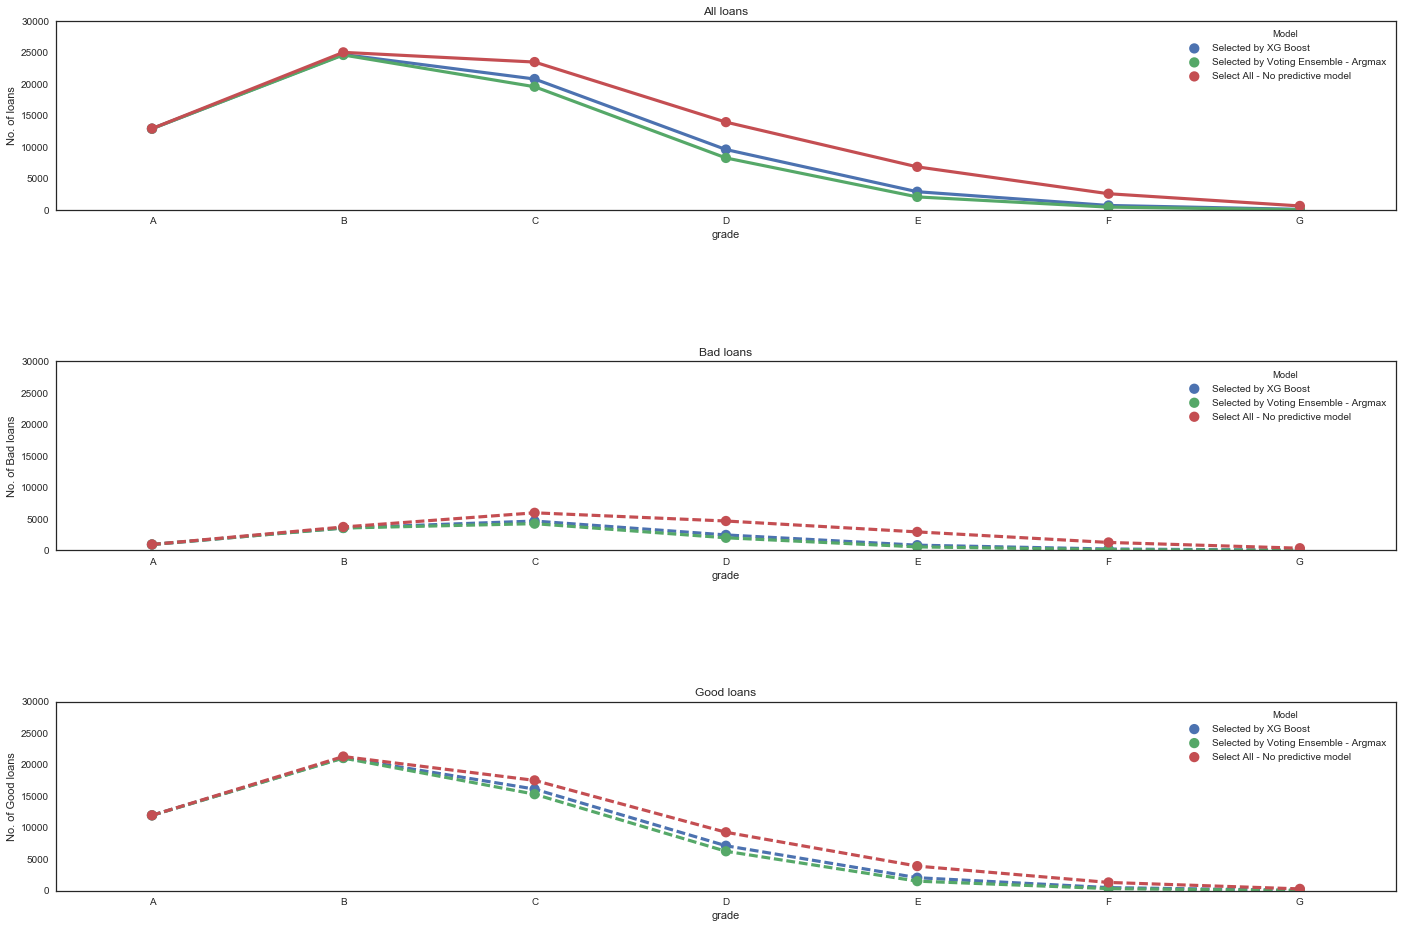

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
plt.subplots_adjust(hspace = 0.8)
ax1 = sns.pointplot('grade',  'Total', hue = 'Model', data = by_grade, ax = ax1 )
ax1.set_ylabel('No. of loans')
ax1.set_title( 'All loans')
ax1.set_ylim(0, 30000)
sns.pointplot('grade','Bad', hue = 'Model', data = by_grade, linestyles= '--', ax = ax2 )
ax2.set_ylabel('No. of Bad loans')
ax2.set_title( 'Bad loans')
ax2.set_ylim(0, 30000)
sns.pointplot('grade','Good', hue = 'Model', data = by_grade, linestyles= '--', ax = ax3 )
ax3.set_ylabel('No. of Good loans')
ax3.set_title( 'Good loans')
ax3.set_ylim(0, 30000)

From the above chart, we see that both models have practically retained almost all of the Grade A and B loans and have been selective on Grades C & above. 


# 5.	Conclusion

Like any credit risk prediction, the Lending Club loan default prediction is not an easy task. The overall results from all the Predictive Models shows promise, but there’s room for improvement of the model accuracy. The AUC score of 0.74 & F1 weighted weighted score of 0.76 is not really ideal, but at the same time, the prediction made by this model can certainly be an input for the loan investors’ selection of loans to maximize their return.
There’s scope for more feature engineering and using additional features which are present in the recent datasets from LendingClub. 

## Appendix

### Code for Hyperparameter tuning

### Hyper Parameter tuning for Light GBM

In [78]:
# Create a smaller size training set for cross validation & hyper parameter tuning
loans_subset = pdml.ModelFrame(loans.drop(['grade', 'roi_inv'], axis = 1).sample(60000 ))
mini_train_loans, mini_test_loans = loans_subset.model_selection.train_test_split(test_size = 0.20, random_state = 6)

#initialize scores list and parameter values
mini_train_lgb = lgb.Dataset(mini_train_loans.data, label=mini_train_loans.target)

In [82]:
lgbmscores = pd.DataFrame()
num_leaves = [300, 500]
max_depth = [5, 7]
param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 500, 'max_depth' : 7, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf' : 350}
#Test 1 - num_leaves and max_depth . Fix these first as they have the maximum impact
for param1_val in num_leaves  :
    param.update(num_leaves = param1_val)
    for param2_val in max_depth :
        param.update(max_depth = param2_val)
        lgbm_cv=lgb.train(param,mini_train_lgb,num_round)
        lgbmscores = lgbmscores.append(score_the_model(mini_train_loans, mini_test_loans, lgbm_cv,param, use_PredictProba=False), 
                          ignore_index=True)

lgbmscores

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.721388,0.888516,0.766750,0.851187,0.753849,0.844457,0.401795,0.470470,0.350615,0.855132,0.825935,0.886469,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.418326,0.735660
1,0.713263,0.948930,0.760833,0.900396,0.748550,0.897518,0.391949,0.453654,0.345021,0.851141,0.823712,0.880459,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.410397,0.870583
2,0.721388,0.888516,0.766750,0.851187,0.753849,0.844457,0.401795,0.470470,0.350615,0.855132,0.825935,0.886469,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.418326,0.735660
3,0.713263,0.948930,0.760833,0.900396,0.748550,0.897518,0.391949,0.453654,0.345021,0.851141,0.823712,0.880459,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.410397,0.870583


Based on the above and prioritizing Test AUC score, fixing num_leaves to be 300 and max_depth = 5 for next level of tuning for the remaining parameters

In [83]:
lgbmscores = pd.DataFrame()
learning_rate = [0.05, 0.10, 0.15]
min_data_in_leaf = [250, 300, 350]

param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.15, 'max_bin': 200, 'min_data_in_leaf' : 350}
#Test 1 - num_leaves and max_depth . Fix these first as they have the maximum impact
for param1_val in learning_rate  :
    param.update(learning_rate = param1_val)
    for param2_val in min_data_in_leaf :
        param.update(min_data_in_leaf = param2_val)
        lgbm_cv=lgb.train(param,mini_train_lgb,num_round)
        lgbmscores = lgbmscores.append(score_the_model(mini_train_loans, mini_test_loans, lgbm_cv,param, use_PredictProba=False), 
                          ignore_index=True)

lgbmscores

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.731435,0.830576,0.770667,0.815312,0.754701,0.802920,0.393565,0.480883,0.333085,0.858596,0.823721,0.896555,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.432002,0.616585
1,0.730649,0.827964,0.772000,0.814937,0.756462,0.802668,0.398946,0.485302,0.338680,0.859317,0.824958,0.896663,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.430892,0.614521
2,0.730687,0.823971,0.770667,0.811854,0.754604,0.799201,0.393030,0.480842,0.332339,0.858625,0.823593,0.896770,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.430526,0.604700
3,0.725930,0.871190,0.765083,0.839875,0.751070,0.831316,0.391802,0.464688,0.338680,0.854428,0.823512,0.887756,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.421924,0.700514
4,0.724320,0.867158,0.766000,0.837500,0.752158,0.828784,0.394828,0.467586,0.341664,0.854959,0.824221,0.888078,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.423023,0.692537
5,0.726271,0.862308,0.766750,0.834750,0.751940,0.825701,0.391125,0.469207,0.335323,0.855744,0.823284,0.890868,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.422919,0.681669
6,0.716375,0.903039,0.761333,0.862000,0.747923,0.855950,0.386724,0.453997,0.336815,0.851837,0.822395,0.883464,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.412687,0.769338
7,0.718688,0.895862,0.766583,0.857083,0.753673,0.850799,0.401368,0.469970,0.350242,0.855028,0.825835,0.886361,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.415674,0.752881
8,0.721388,0.888516,0.766750,0.851187,0.753849,0.844457,0.401795,0.470470,0.350615,0.855132,0.825935,0.886469,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.418326,0.735660


Based on the above and prioritizing Test AUC score, fixing learning_rate to be 0.05 and min_data_in_leaf to 300 for next level of tuning for the remaining parameters

In [84]:
max_bin = [100, 150, 200]
lgbmscores = pd.DataFrame()

param = {'objective':'binary', 'metric' :['auc', 'f1_weighted'], 
        'num_leaves': 300, 'max_depth' : 5, 'learning_rate': 0.05, 'max_bin': 200, 'min_data_in_leaf' : 300}
#Test 1 - num_leaves and max_depth . Fix these first as they have the maximum impact
for param1_val in max_bin  :
    param.update(max_bin = param1_val)
    lgbm_cv=lgb.train(param,mini_train_lgb,num_round)
    lgbmscores = lgbmscores.append(score_the_model(mini_train_loans, mini_test_loans, lgbm_cv,param, use_PredictProba=False), 
                          ignore_index=True)

lgbmscores

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.730649,0.827964,0.772,0.814937,0.756462,0.802668,0.398946,0.485302,0.33868,0.859317,0.824958,0.896663,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.430892,0.614521
1,0.730649,0.827964,0.772,0.814937,0.756462,0.802668,0.398946,0.485302,0.33868,0.859317,0.824958,0.896663,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.430892,0.614521
2,0.730649,0.827964,0.772,0.814937,0.756462,0.802668,0.398946,0.485302,0.33868,0.859317,0.824958,0.896663,"{'objective': 'binary', 'metric': ['auc', 'f1_...",0.430892,0.614521


The parameter max_bin seems to give the same result for different values, so taking the min value for the same in the tuned model.

### Hyper Parameter tuning for XG Boost

In [85]:
#Test 1 - no of estimators, max_depth and learning rate
xg_cv_scores = pd.DataFrame()
xg_est_cv = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.15, min_child_weight=1, max_depth=5, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=300)

n_estimators = [300, 400]
max_depth = [4, 5, 7]
learning_rate = [0.05, 0.10]
#param_1 = param_test1.ke
for param1_val in n_estimators  :
    xg_est_cv.set_params(n_estimators = param1_val)
    for param2_val in max_depth :
        xg_est_cv.set_params(max_depth = param2_val)
        for param3_val in learning_rate :
            xg_est_cv.set_params(learning_rate = param3_val)
            xg_est_cv.fit(mini_train_loans.data, mini_train_loans.target, eval_metric = 'auc')
            xg_cv_scores = xg_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, xg_est_cv, 
                                                                model_key= xg_est_cv.get_params(), use_PredictProba=True), 
                                                ignore_index = True)
xg_cv_scores
            

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
----------------------------

,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
0,0.730860,0.784905,0.771250,0.794042,0.752711,0.776775,0.380781,0.481735,0.314808,0.859713,0.820746,0.902565,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.432014,0.539395
1,0.729164,0.815717,0.771000,0.810958,0.754326,0.797159,0.390417,0.481664,0.328236,0.859019,0.822963,0.898380,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.434173,0.602701
2,0.730832,0.820963,0.770500,0.811792,0.752842,0.797591,0.383893,0.479598,0.320030,0.858986,0.821467,0.900097,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431841,0.610910
3,0.728247,0.864720,0.766250,0.839146,0.750296,0.829353,0.383652,0.466845,0.325625,0.855777,0.821520,0.893014,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.425928,0.700467
4,0.728262,0.914462,0.770583,0.873500,0.752806,0.866526,0.383427,0.479821,0.319284,0.859073,0.821359,0.900418,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.427848,0.804526
5,0.717347,0.966785,0.766167,0.923333,0.749838,0.920942,0.381393,0.466307,0.322641,0.855836,0.820996,0.893765,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.413624,0.920727
6,0.731439,0.797696,0.772167,0.800708,0.754286,0.784866,0.386445,0.485070,0.321149,0.860111,0.822005,0.901921,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431772,0.564048
7,0.727376,0.833720,0.768833,0.821375,0.752837,0.809465,0.389256,0.475013,0.329728,0.857437,0.822764,0.895160,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429879,0.637705
8,0.730216,0.839366,0.769083,0.822562,0.752344,0.810053,0.385724,0.475410,0.324506,0.857817,0.821927,0.896985,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.429349,0.648735
9,0.725585,0.889042,0.766583,0.856437,0.750945,0.848714,0.386149,0.468119,0.328609,0.855893,0.822099,0.892585,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.422551,0.751674


In [86]:
#Getting param values for the cv with the best AUC Test score, no of estimators = 400, max_depth = 4 and learning rate = 0.05
xg_cv_scores.loc[6]['Model']

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_delta_step': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 4,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 4,
 'silent': False,
 'subsample': 0.8}

In [87]:
#Test 2 - min_child_weight, max_delta_step and gamma
xg_cv_scores = pd.DataFrame()
xg_est_cv = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.05, min_child_weight=1, max_depth=4, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=400)

min_child_weight = [1,2]
max_delta_step = [1,2]
gamma = [0.1, 0.2]
#param_1 = param_test1.ke
for param1_val in min_child_weight  :
    xg_est_cv.set_params(min_child_weight = param1_val)
    for param2_val in max_delta_step :
        xg_est_cv.set_params(max_delta_step = param2_val)
        for param3_val in gamma :
            xg_est_cv.set_params(gamma = param3_val)
            xg_est_cv.fit(mini_train_loans.data, mini_train_loans.target, eval_metric = 'auc')
            xg_cv_scores = xg_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, xg_est_cv, 
                                                                model_key= xg_est_cv.get_params(), use_PredictProba=True), 
                                                ignore_index = True)
xg_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
3,0.732316,0.801964,0.771000,0.803271,0.752518,0.787786,0.380523,0.480912,0.314808,0.859538,0.820693,0.902243,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.434120,0.573053
2,0.732113,0.802387,0.770583,0.803208,0.752196,0.787470,0.380095,0.479545,0.314808,0.859246,0.820605,0.901706,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.433880,0.573480
6,0.731870,0.801486,0.772583,0.802312,0.754000,0.786826,0.383555,0.486254,0.316673,0.860573,0.821338,0.903745,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.434654,0.571465
7,0.731718,0.801360,0.772750,0.801854,0.754333,0.786342,0.384841,0.486872,0.318165,0.860633,0.821624,0.903530,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.434309,0.571171
0,0.731439,0.797696,0.772167,0.800708,0.754286,0.784866,0.386445,0.485070,0.321149,0.860111,0.822005,0.901921,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431772,0.564048
1,0.731415,0.797757,0.771500,0.800271,0.753058,0.784464,0.381876,0.482621,0.315927,0.859845,0.820986,0.902565,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431823,0.564411
4,0.731401,0.797360,0.769833,0.800250,0.751051,0.784286,0.376242,0.476817,0.310705,0.858880,0.819760,0.901921,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.432242,0.563393
5,0.731134,0.797825,0.770583,0.799958,0.752502,0.784025,0.381765,0.479684,0.317046,0.859160,0.820982,0.901062,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.432688,0.564333


In [88]:
#Getting param values for the cv with the best AUC Test score, min_child_weight = 1, max_delta_step = 2 and gamma = 0.2
xg_cv_scores.loc[3]['Model']

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'eval_metric': 'auc',
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_delta_step': 2,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 4,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 4,
 'silent': False,
 'subsample': 0.8}

In [89]:
#Test 3 - subsample, colsample_bytree and colsample_bylevel
xg_cv_scores = pd.DataFrame()
xg_est_cv = loans_mf.xgboost.XGBClassifier(booster = 'gbtree',n_jobs=-1, silent=False,
                                        learning_rate=0.05, min_child_weight=1, max_depth=4, gamma=0.1, max_delta_step=1,
                                        subsample=0.8, colsample_bytree = 0.8, scale_pos_weight=1, 
                                        objective='binary:logistic', eval_metric = 'auc', random_state=4,
                                        missing=None, n_estimators=400)

subsample = [0.6, 0.8]
colsample_bytree = [0.6,0.8]
colsample_bylevel = [0.8, 1]
#param_1 = param_test1.ke
for param1_val in subsample  :
    xg_est_cv.set_params(subsample = param1_val)
    for param2_val in colsample_bytree :
        xg_est_cv.set_params(colsample_bytree = param2_val)
        for param3_val in colsample_bylevel :
            xg_est_cv.set_params(colsample_bylevel = param3_val)
            xg_est_cv.fit(mini_train_loans.data, mini_train_loans.target, eval_metric = 'auc')
            xg_cv_scores = xg_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, xg_est_cv, 
                                                                model_key= xg_est_cv.get_params(), use_PredictProba=True), 
                                                ignore_index = True)
xg_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
4,0.732039,0.795935,0.771417,0.799500,0.753096,0.783216,0.382346,0.482386,0.316673,0.859758,0.821094,0.902243,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.434940,0.561077
0,0.732006,0.793560,0.772417,0.799083,0.754631,0.783048,0.387531,0.485939,0.322268,0.860243,0.822246,0.901921,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.435237,0.556480
5,0.731973,0.796167,0.769750,0.800979,0.751501,0.785057,0.378962,0.476810,0.314435,0.858677,0.820367,0.900740,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.432995,0.562818
1,0.731657,0.794787,0.770833,0.799646,0.752440,0.783531,0.380631,0.480387,0.315181,0.859407,0.820721,0.901921,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.434400,0.559481
7,0.731439,0.797696,0.772167,0.800708,0.754286,0.784866,0.386445,0.485070,0.321149,0.860111,0.822005,0.901921,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431772,0.564048
3,0.730898,0.797716,0.770667,0.800687,0.752719,0.784742,0.382683,0.480023,0.318165,0.859175,0.821188,0.900848,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.433467,0.563532
2,0.730810,0.795592,0.769917,0.800625,0.751321,0.784454,0.377452,0.477195,0.312197,0.858881,0.820027,0.901599,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.431614,0.559116
6,0.730154,0.796544,0.771417,0.800125,0.753754,0.784032,0.385941,0.482643,0.321522,0.859571,0.821911,0.900848,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.433891,0.562968


In [90]:
#Getting param values for the cv with the best AUC Test score, subsample = 0.8, colsample_bylevel = 0.8, colsample_bytree = 0.6
xg_cv_scores.loc[4]['Model']

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.8,
 'colsample_bytree': 0.6,
 'eval_metric': 'auc',
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_delta_step': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'binary:logistic',
 'random_state': 4,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 4,
 'silent': False,
 'subsample': 0.8}

### Hyper Parameter tuning for RandomForest

In [91]:
rf_est_cv = loans_mf.ensemble.RandomForestClassifier(n_estimators = 200, criterion = 'gini', class_weight = 'balanced',
                                                 max_depth = None, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                                  max_features = 'auto', max_leaf_nodes = None, oob_score = True )

In [92]:
#Test 1 -n_estimators & max_depth
rf_est_cv = loans_mf.ensemble.RandomForestClassifier(n_estimators = 200, criterion = 'gini', class_weight = 'balanced',
                                                 max_depth = None, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                                  max_features = 'auto', max_leaf_nodes = None, oob_score = True )
rf_est_cv_scores = pd.DataFrame()

n_estimators = [ 200, 300, 400]
max_depth = [7, 9]
for param1_val in n_estimators  :
    rf_est_cv.set_params(n_estimators = param1_val)
    for param2_val in max_depth :
        rf_est_cv.set_params(max_depth = param2_val)
        rf_est_cv.fit(mini_train_loans.data, mini_train_loans.target)
        rf_est_cv_scores = rf_est_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, rf_est_cv, 
                                                                model_key= 'n_estimators= '+str(param1_val)+' max_depth= '+str(param2_val), use_PredictProba=True), 
                                                ignore_index = True)
rf_est_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
5,0.715165,0.800341,0.556667,0.596333,0.589058,0.624306,0.447674,0.310171,0.804178,0.629733,0.896019,0.485460,n_estimators= 400 max_depth= 9,0.406754,0.551747
1,0.714783,0.799839,0.559250,0.598125,0.591588,0.626129,0.449808,0.311887,0.806416,0.632376,0.897593,0.488143,n_estimators= 200 max_depth= 9,0.406832,0.548561
3,0.714547,0.800073,0.557167,0.597417,0.589493,0.625387,0.448526,0.310712,0.806043,0.630047,0.896928,0.485567,n_estimators= 300 max_depth= 9,0.405463,0.549705
0,0.713262,0.748109,0.539833,0.552896,0.570700,0.580787,0.445582,0.304850,0.827676,0.606695,0.902139,0.457023,n_estimators= 200 max_depth= 7,0.408293,0.471584
2,0.712815,0.748268,0.537917,0.550542,0.568523,0.578314,0.445555,0.304372,0.831033,0.603900,0.903205,0.453589,n_estimators= 300 max_depth= 7,0.406768,0.471122
4,0.712791,0.748372,0.536500,0.550021,0.567056,0.577721,0.444688,0.303613,0.830660,0.602260,0.902680,0.451873,n_estimators= 400 max_depth= 7,0.406003,0.473423


From the above , there is not a major difference in scores even if the no of trees is more than 200. So it can be fixed at 200 to save execution time. Same is the case with max_depth, the default param value can be accepted.

In [93]:
#Test 2 -max_features
rf_est_cv = loans_mf.ensemble.RandomForestClassifier(n_estimators = 300, criterion = 'gini', class_weight = 'balanced',
                                                 max_depth = None, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0, 
                                                  max_features = 'auto', max_leaf_nodes = None, oob_score = True )
rf_est_cv_scores = pd.DataFrame()

max_features = [14, 20, 30]
for param1_val in max_features  :
    rf_est_cv.set_params(max_features = param1_val)
    rf_est_cv.fit(mini_train_loans.data, mini_train_loans.target)
    rf_est_cv_scores = rf_est_cv_scores.append (score_the_model(mini_train_loans, mini_test_loans, rf_est_cv, 
                                                                model_key= 'max_features= '+str(param1_val), use_PredictProba=True), 
                                                ignore_index = True)
rf_est_cv_scores.sort_values('AUC (Test)', ascending = False)

-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


,AUC (Test),AUC (Train),Accuracy (Test),Accuracy (Train),F1-Weighted (Test),F1-Weighted (Train),Label-Bad F1 (Test),Label-Bad Precision (Test),Label-Bad Recall (Test),Label-Good F1 (Test),Label-Good Precision (Test),Label-Good Recall (Test),Model,Precision (Test),Precision (Train)
1,0.717146,1.0,0.765000,1.0,0.736539,1.0,0.313535,0.451296,0.240209,0.858234,0.807339,0.915978,max_features= 20,0.396948,1.0
0,0.716517,1.0,0.769667,1.0,0.739479,1.0,0.315164,0.469373,0.237225,0.861551,0.807891,0.922846,max_features= 14,0.397548,1.0
2,0.713580,1.0,0.765500,1.0,0.737227,1.0,0.315661,0.453529,0.242074,0.858508,0.807740,0.916085,max_features= 30,0.394143,1.0


Increasing max_features to be more than the default sqrt(no of features) doesn't improve the test performance much. So the default parameter value can be accepted.